# Predictive Modeling and Customer Segmentation
**Marketing Campaign Dataset – XGBoost, SHAP, and SOM Analysis**

This notebook presents a complete predictive modeling and unsupervised segmentation analysis using a real-world marketing dataset. 
The objective is twofold:

1. Predict which customers are likely to respond to a future marketing campaign using **XGBoost**.
2. Reveal underlying customer segments using **Self-Organizing Maps (SOM)**, providing actionable insights for consultants.

This is intended for a data science and marketing consulting audience, such as a team at **Blend360**.


## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings("ignore")



##  Load dataset and create features

###  Load and Explore

In [2]:
# Load data
df = pd.read_csv("marketing_campaign.csv", sep=";")

In [3]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   
2  2013-08-21       26       426  ...                  4             0   
3  2014-02-10       26        11  ...                  6             0   
4  2014-01-19       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [4]:
df.Education.unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [5]:
df.Marital_Status.unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
pd.set_option("display.max_columns", None)

df.describe()

ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.444196     0.506250   
std     3246.662198    11.984069   25173.076661     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min       0.000000     0.000000     0.000000         0.000000   
25%      24.000000    23.750000     1.000000        16.000000   
50%      49.000000   173.500000     8.000000        67.000000   
75%      74.000000   504.250000    33.000000       232.000000   
max      99.000000  1493.000000   199.000000      1725.000000   

       MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
count      2240.000000       2240.000000   2240.000000        2240.000000   
mean         37.525446         27.062946     44.021875           2.325000   
std          54.628979         41.280498     52.167439           1.932238   
min           0.000000          0.000000      0.000000           0.000000   
25%           3.000000          1.000000      9.000000           1.000000   
50%          12.000000          8.000000     24.000000           2.000000   
75%          50.000000         33.000000     56.000000           3.000000   
max         259.000000        263.000000    362.000000          15.000000   

       NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
count      2240.000000          2240.000000        2240.000000   
mean          4.084821             2.662054           5.790179   
std           2.778714             2.923101           3.250958   
min           0.000000             0.000000           0.000000   
25%           2.000000             0.000000           3.000000   
50%           4.000000             2.000000           5.000000   
75%           6.000000             4.000000           8.000000   
max          27.000000            28.000000          13.000000   

       NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
count        2240.000000   2240.000000   2240.000000   2240.000000   
mean            5.316518      0.072768      0.074554      0.072768   
std             2.426645      0.259813      0.262728      0.259813   
min             0.000000      0.000000      0.000000      0.000000   
25%             3.000000      0.000000      0.000000      0.000000   
50%             6.000000      0.000000      0.000000      0.000000   
75%             7.000000      0.000000      0.000000      0.000000   
max            20.000000      1.000000      1.000000      1.000000   

       AcceptedCmp1  AcceptedCmp2     Complain  Z_CostContact  Z_Revenue  \
count   2240.000000   2240.000000  2240.000000         2240.0     2240.0   
mean       0.064286      0.013393     0.009375            3.0       11.0   
std        0.245316      0.114976     0.096391            0.0        0.0   
min        0.000000      0.000000     0.000000            3.0       11.0   
25%        0.000000      0.000000     0.000000            3.0       11.0   
50%        0.000000      0.000000     0.000000            3.0       11.0   
75%        0.000000      0.000000     0.000000            3.0       11.0   
max        1.000000      1.000000     1.000000            3.0       11.0   

          Response  
count  2240.000000  
mean      0.149107  
std       0.356274  
min       0.000000  
25%       0.000000  
50%   

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split



# Convert Dt_Customer to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
reference_date = pd.Timestamp('2014-09-01')

months = (
    (reference_date.year - df['Dt_Customer'].dt.year) * 12 +
    (reference_date.month - df['Dt_Customer'].dt.month)
)

# -1 if day dont match with reference_date
adjust = (reference_date.day < df['Dt_Customer'].dt.day).astype(int)
df['Months_As_Customer'] = (months - adjust).astype(int)
# Calculate Age
df['Age'] = 2014 - df['Year_Birth']

# Combine Kidhome and Teenhome to reduce columns
df['Total_Kids'] = df['Kidhome'] + df['Teenhome']

# Calculate Total_Spent to see if total amount tell something 
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spent'] = df[spending_cols].sum(axis=1)

# Drop columns irrelevant, age already calculated up there
df.drop(columns=['ID', 'Year_Birth', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer'], inplace=True)


# Map Education to ordered cardinality, cause XGboost, even when do efficients categorical partitions, may dont capture
education_order = {
    'Basic': 0,
    '2n Cycle': 1,
    'Graduation': 2,
    'Master': 3,
    'PhD': 4
}
df['Education'] = df['Education'].map(education_order).astype('int')

# Convert Marital_Status to categorical for native XGBoost handling
df['Marital_Status'] = df['Marital_Status'].astype('category')

# Define X and y
X = df.drop(columns=['Response'])
y = df['Response']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Output shapes
X_train.shape, X_test.shape


((1792, 27), (448, 27))

### 2.2. EDA

In [9]:
num = X.select_dtypes(include=[np.number])


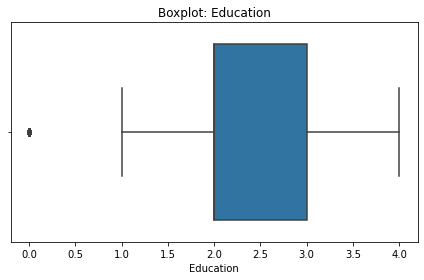

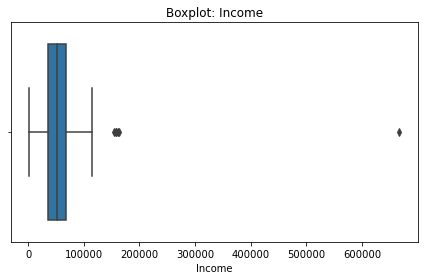

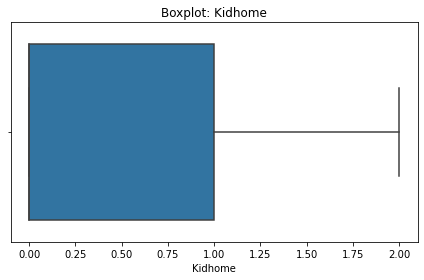

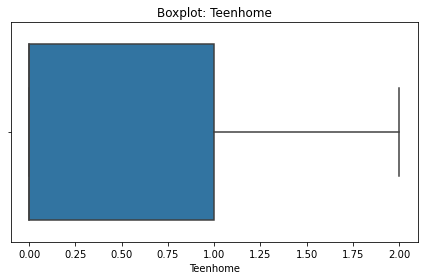

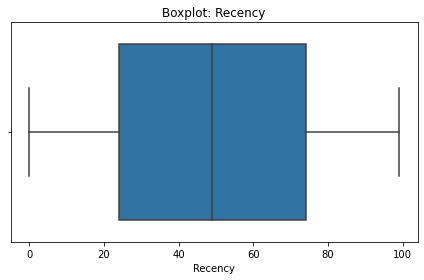

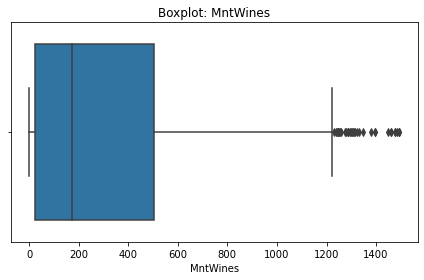

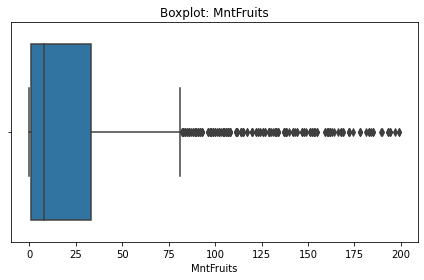

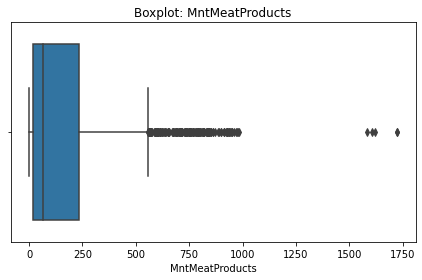

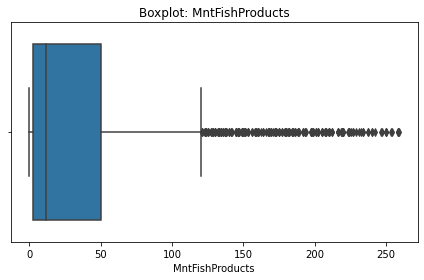

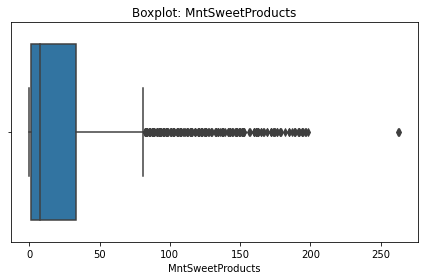

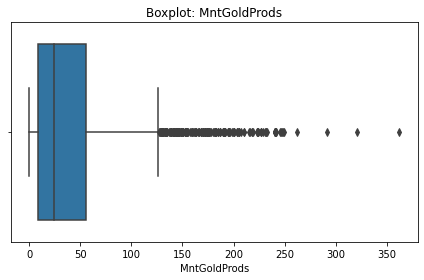

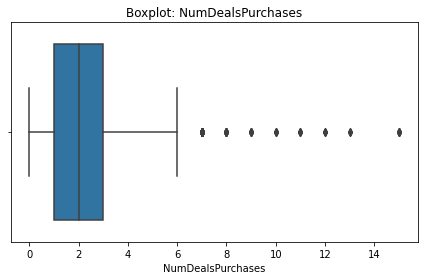

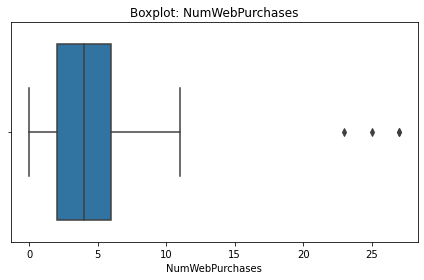

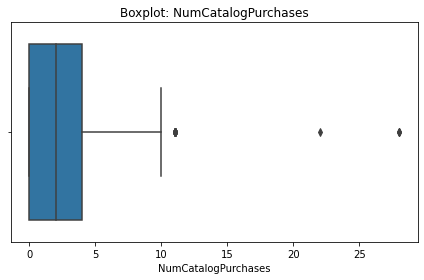

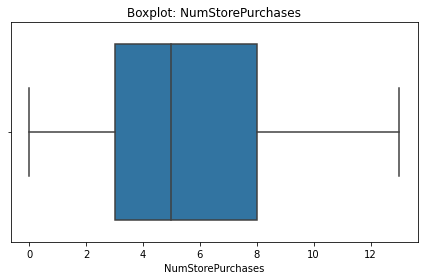

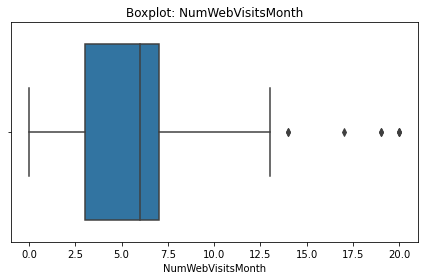

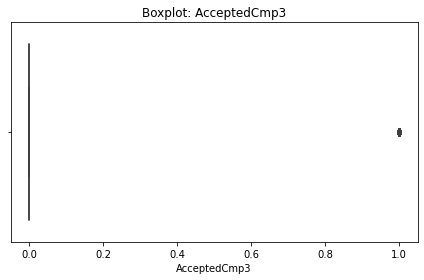

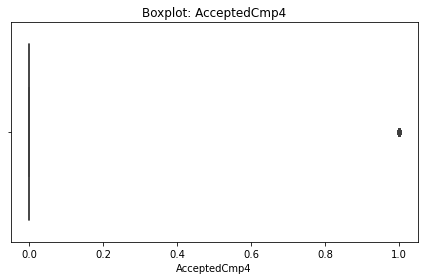

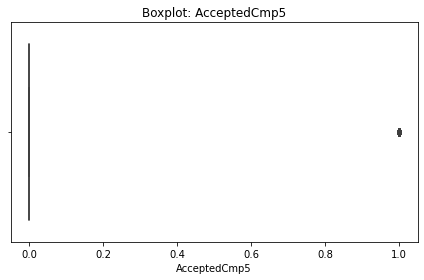

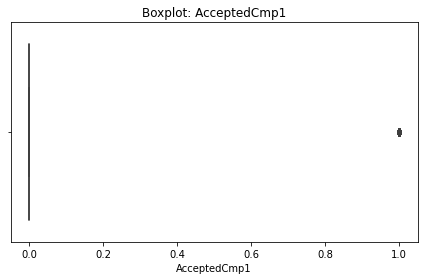

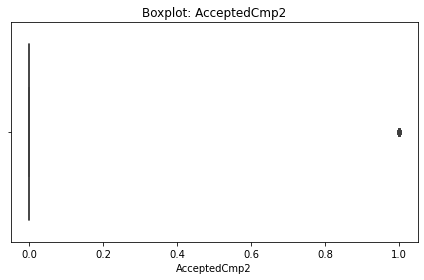

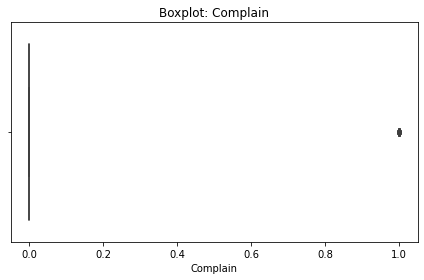

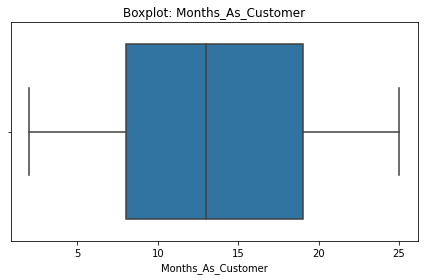

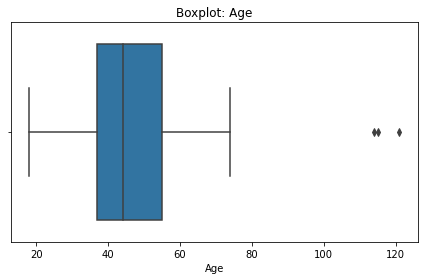

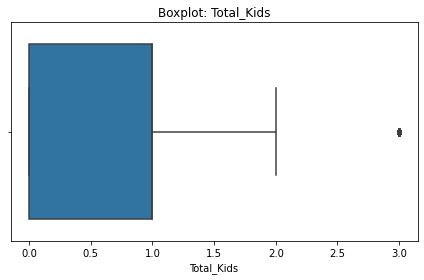

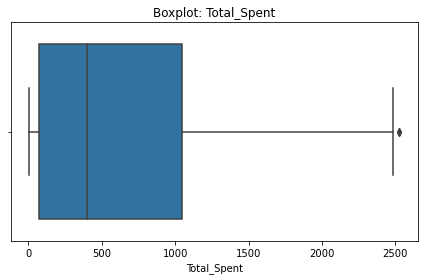

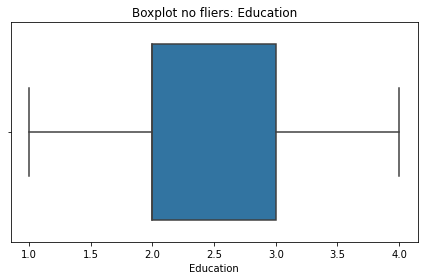

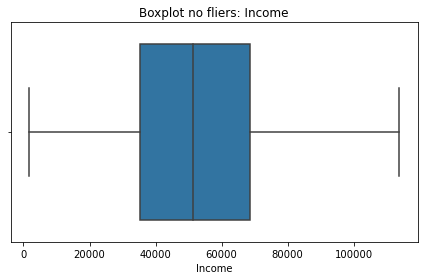

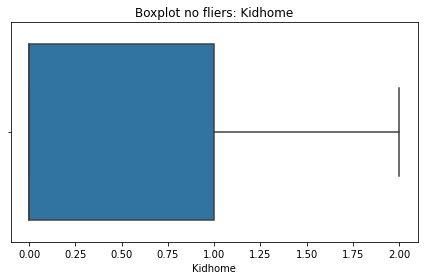

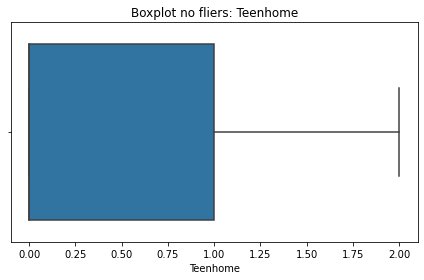

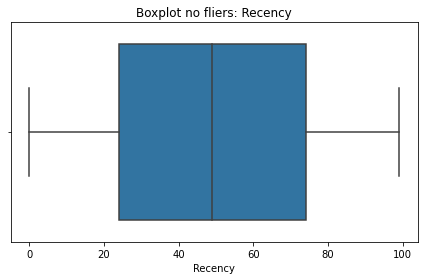

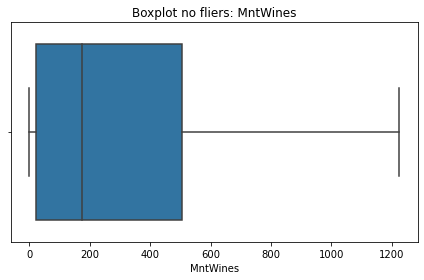

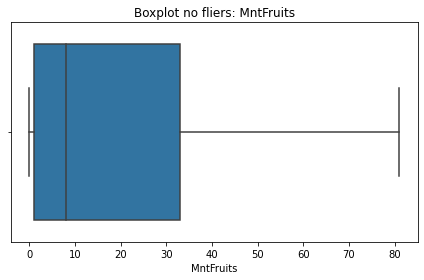

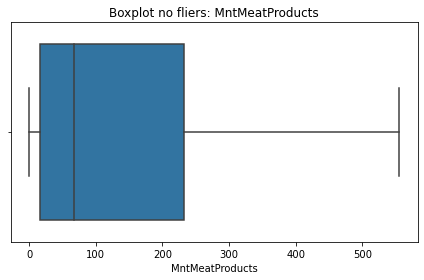

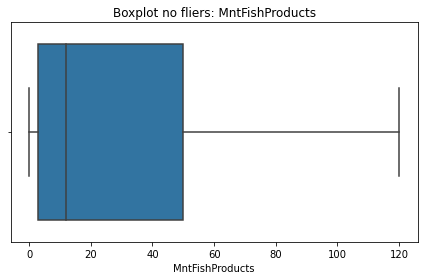

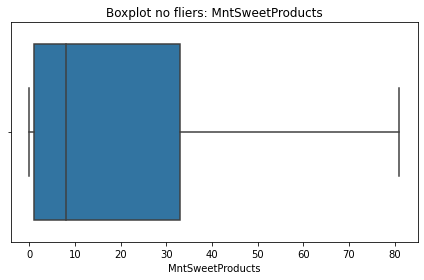

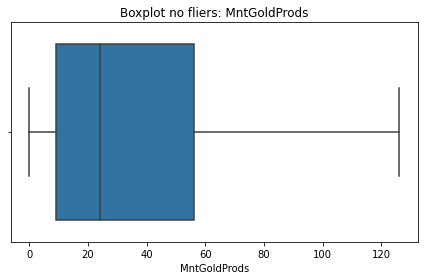

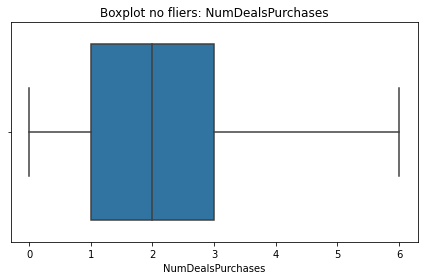

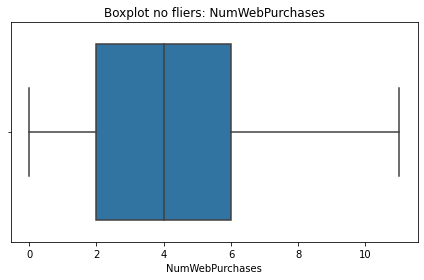

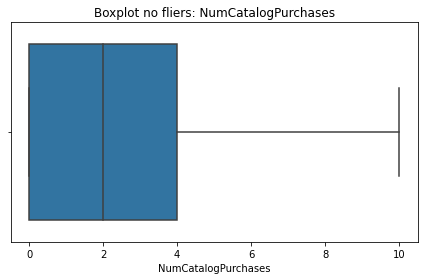

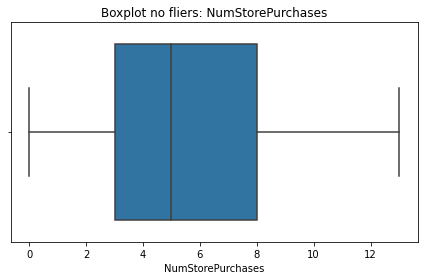

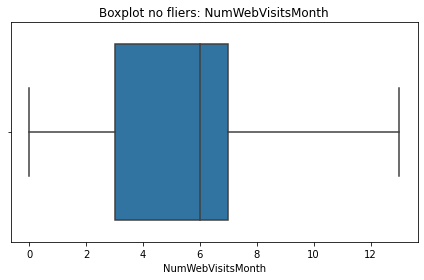

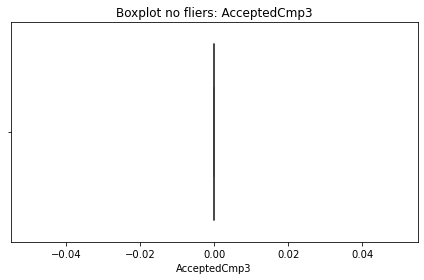

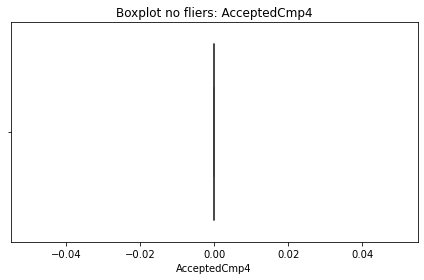

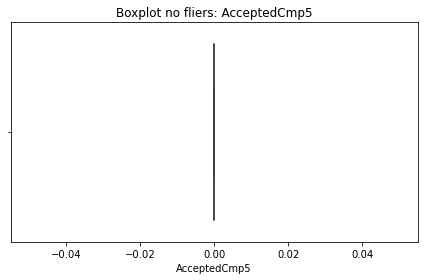

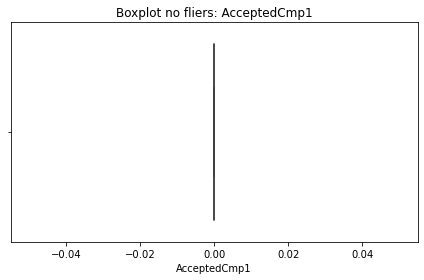

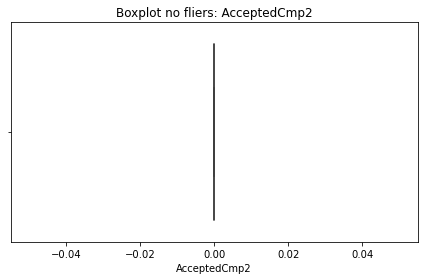

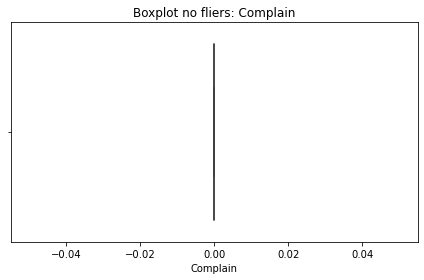

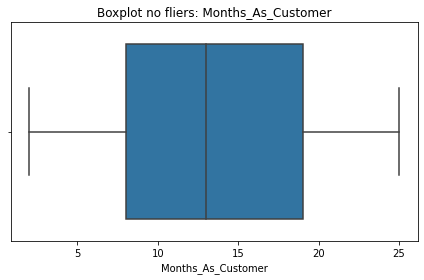

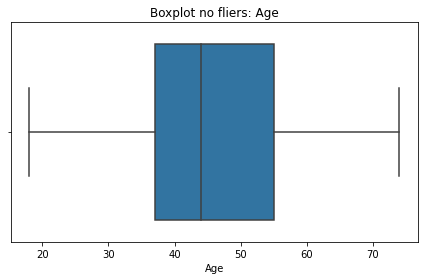

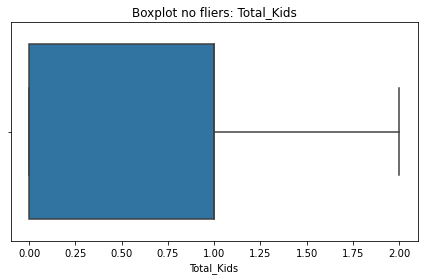

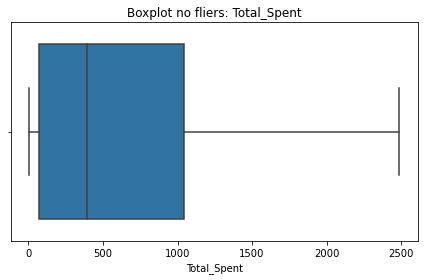

In [10]:
for col in num.columns:
    plt.figure()                         # nueva figura
    sns.boxplot(x=num[col].dropna(), orient="h")
    plt.title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()
for col in num.columns:
    plt.figure()                         # nueva figura
    sns.boxplot(x=num[col].dropna(), orient="h", showfliers=False)
    plt.title(f"Boxplot no fliers: {col}")
    plt.tight_layout()
    plt.show()


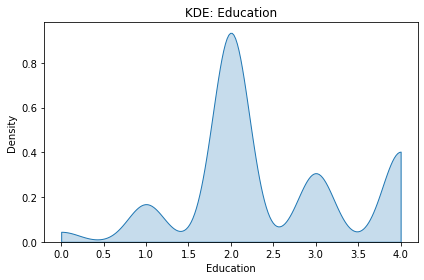

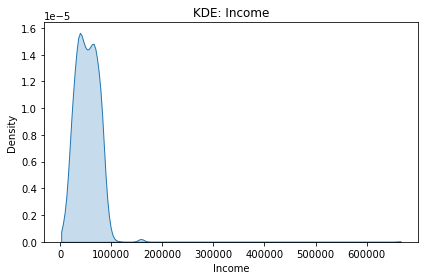

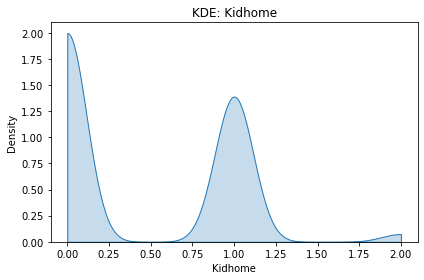

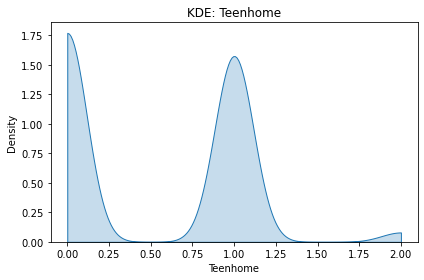

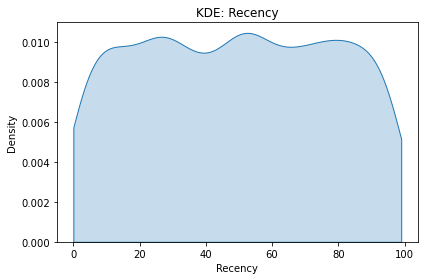

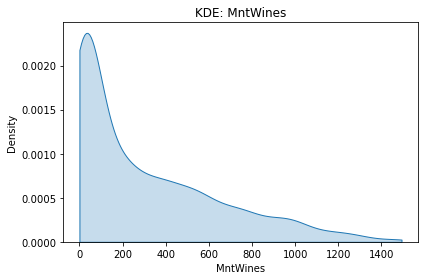

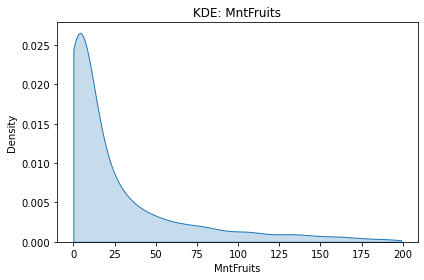

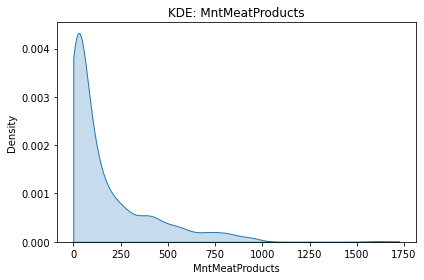

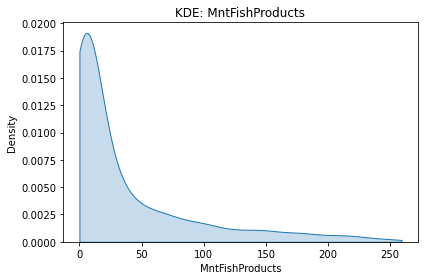

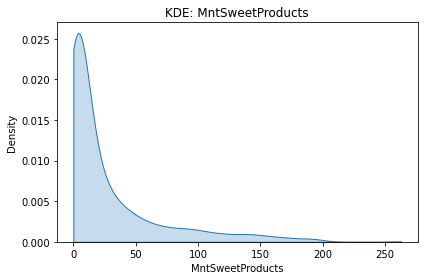

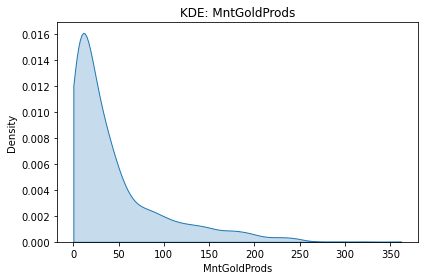

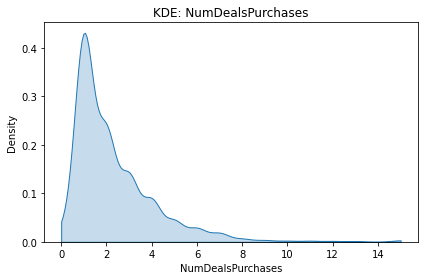

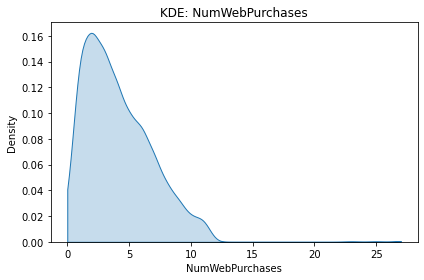

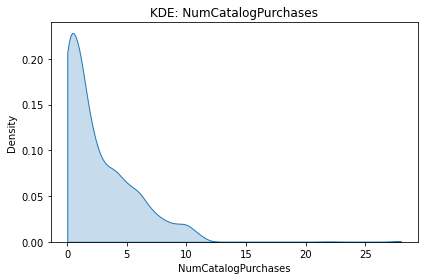

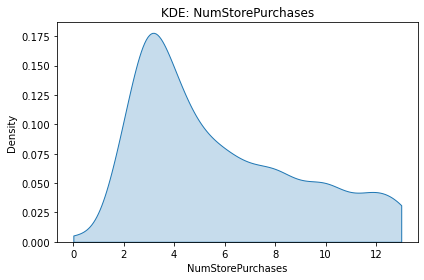

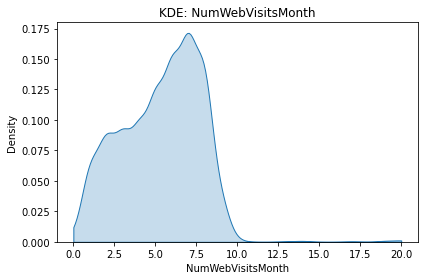

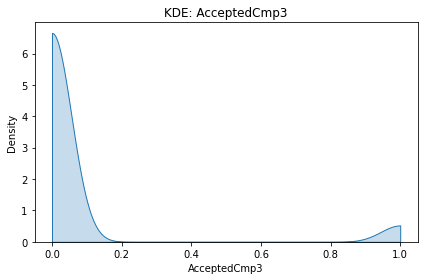

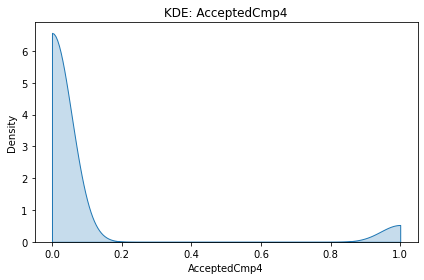

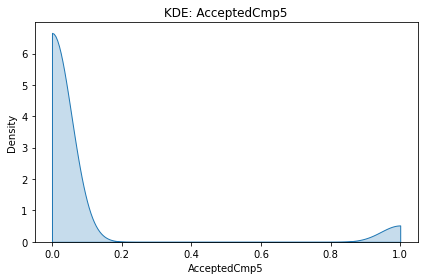

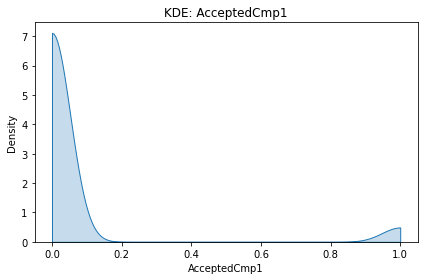

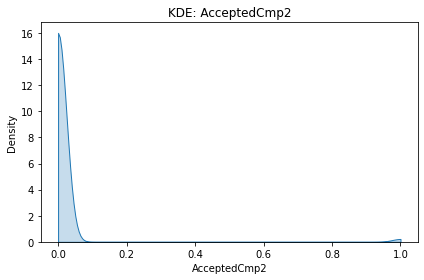

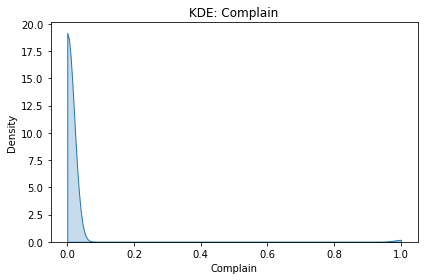

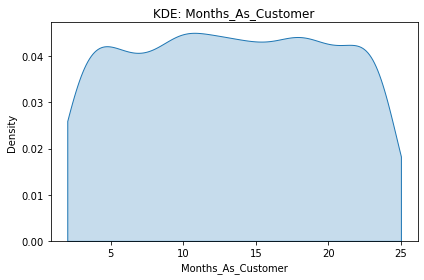

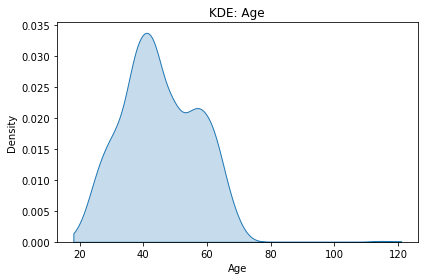

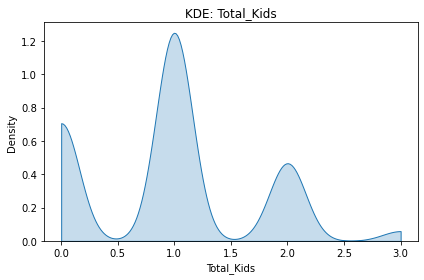

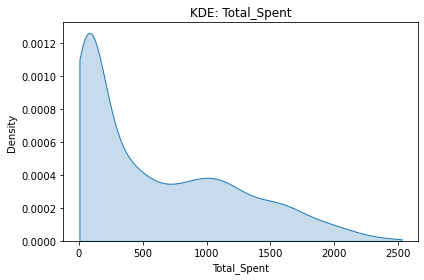

In [11]:
for col in num.columns:
    plt.figure()
    sns.kdeplot(x=num[col].dropna(), fill=True, bw_adjust=1.0, cut=0)  # cut=0 evita extenderse fuera de los datos
    plt.title(f"KDE: {col}")
    plt.tight_layout()
    plt.show()

In [12]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Asegúrate de usar solo columnas numéricas
df_num = df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación (Pearson o Spearman)
corr_matrix = df_num.corr(method='pearson')  # Cambia a 'spearman' si quieres

# Crear el heatmap interactivo
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu_r',
    zmin=-1, zmax=1,
    hoverongaps=False,
    colorbar=dict(title='Correlación')
))

# Mejoras visuales
fig.update_layout(
    title='Matriz de Correlación Interactiva',
    xaxis_nticks=len(corr_matrix.columns),
    yaxis_nticks=len(corr_matrix.columns),
    autosize=False,
    width=900,
    height=800
)

fig.show()

In [13]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Asegúrate de usar solo columnas numéricas
df_num = df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación (Pearson o Spearman)
corr_matrix = df_num.corr(method='spearman')  # Cambia a 'spearman' si quieres

# Crear el heatmap interactivo
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu_r',
    zmin=-1, zmax=1,
    hoverongaps=False,
    colorbar=dict(title='Correlación')
))

# Mejoras visuales
fig.update_layout(
    title='Matriz de Correlación Interactiva',
    xaxis_nticks=len(corr_matrix.columns),
    yaxis_nticks=len(corr_matrix.columns),
    autosize=False,
    width=900,
    height=800
)

fig.show()

## 3. Train XGBoost Classifier

### 3.1 First Approach: No Hyperparams Model


Fold 1 - ROC-AUC Train: 0.9999 | Val: 0.9163
Fold 1 - F1-Score Train:  0.9810 | Val: 0.5747
              precision    recall  f1-score   support

           0     0.9110    0.9738    0.9414       305
           1     0.7576    0.4630    0.5747        54

    accuracy                         0.8969       359
   macro avg     0.8343    0.7184    0.7580       359
weighted avg     0.8880    0.8969    0.8862       359



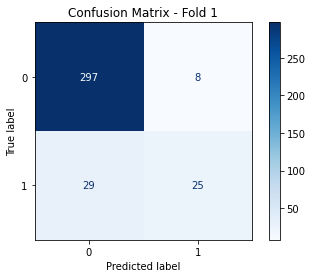


Fold 2 - ROC-AUC Train: 1.0000 | Val: 0.9054
Fold 2 - F1-Score Train:  0.9882 | Val: 0.5393
              precision    recall  f1-score   support

           0     0.9074    0.9639    0.9348       305
           1     0.6857    0.4444    0.5393        54

    accuracy                         0.8858       359
   macro avg     0.7966    0.7042    0.7371       359
weighted avg     0.8741    0.8858    0.8753       359



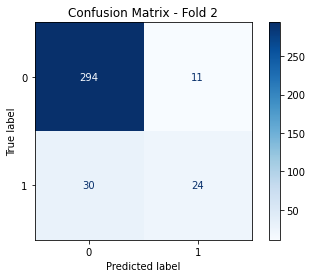


Fold 3 - ROC-AUC Train: 1.0000 | Val: 0.9002
Fold 3 - F1-Score Train:  0.9883 | Val: 0.5238
              precision    recall  f1-score   support

           0     0.9052    0.9705    0.9367       305
           1     0.7097    0.4151    0.5238        53

    accuracy                         0.8883       358
   macro avg     0.8074    0.6928    0.7303       358
weighted avg     0.8763    0.8883    0.8756       358



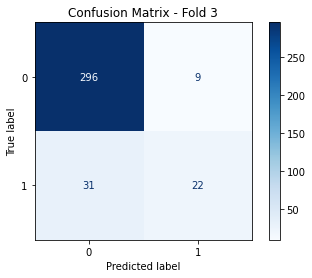


Fold 4 - ROC-AUC Train: 0.9999 | Val: 0.9072
Fold 4 - F1-Score Train:  0.9858 | Val: 0.4598
              precision    recall  f1-score   support

           0     0.8981    0.9541    0.9253       305
           1     0.5882    0.3774    0.4598        53

    accuracy                         0.8687       358
   macro avg     0.7432    0.6657    0.6925       358
weighted avg     0.8523    0.8687    0.8564       358



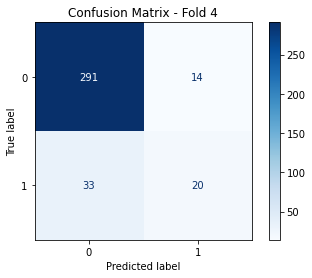


Fold 5 - ROC-AUC Train: 0.9999 | Val: 0.8740
Fold 5 - F1-Score Train:  0.9860 | Val: 0.5684
              precision    recall  f1-score   support

           0     0.9177    0.9508    0.9340       305
           1     0.6429    0.5094    0.5684        53

    accuracy                         0.8855       358
   macro avg     0.7803    0.7301    0.7512       358
weighted avg     0.8770    0.8855    0.8799       358



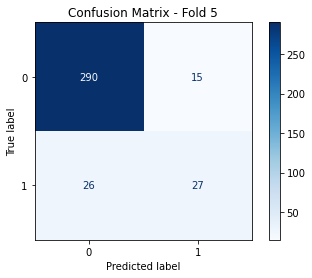


=== AVERAGE SCORES ===
ROC-AUC Train Avg: 0.9999 | Val Avg: 0.9006
F1-Score Train Avg: 0.9859 | Val Avg: 0.5332


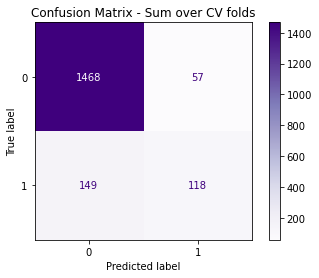

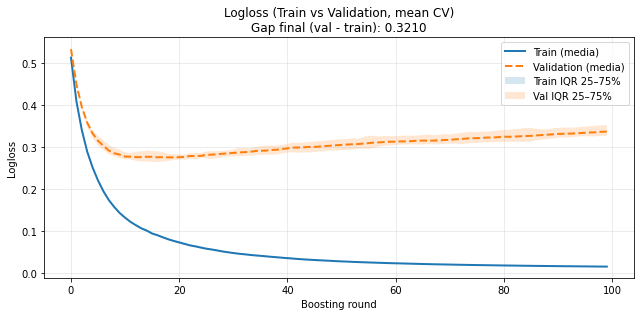

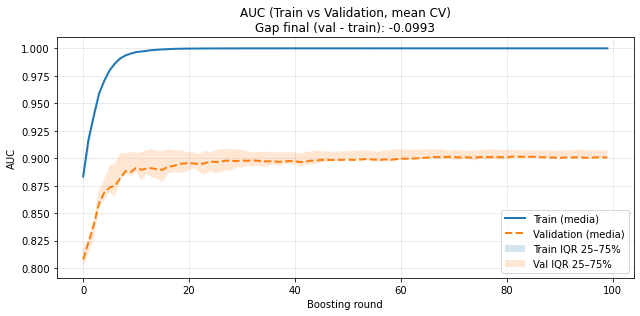

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

# =========================
# Cross Validation
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_auc_scores, val_auc_scores = [], []
train_f1_scores,  val_f1_scores  = [], []
conf_mats = []  # matrices de confusión por fold

# Para curvas por iteración (boosting rounds)
train_logloss_curves, val_logloss_curves = [], []
train_auc_curves,     val_auc_curves     = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = XGBClassifier(
        tree_method='hist',
        enable_categorical=True,
        random_state=42,
        eval_metric=['logloss', 'auc'],
        n_jobs=-1
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],  # train primero = validation_0
        verbose=False
        # early_stopping_rounds=50,               # OPCIONAL: si lo activas, las curvas tendrán distinta longitud
    )

    # -------- Predicciones y métricas por fold --------
    y_tr_pred  = model.predict(X_tr)
    y_tr_proba = model.predict_proba(X_tr)[:, 1]
    y_val_pred  = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    train_auc = roc_auc_score(y_tr, y_tr_proba)
    val_auc   = roc_auc_score(y_val, y_val_proba)
    train_f1  = f1_score(y_tr, y_tr_pred)
    val_f1    = f1_score(y_val, y_val_pred)

    train_auc_scores.append(train_auc);  val_auc_scores.append(val_auc)
    train_f1_scores.append(train_f1);    val_f1_scores.append(val_f1)

    print(f"\nFold {fold} - ROC-AUC Train: {train_auc:.4f} | Val: {val_auc:.4f}")
    print(f"Fold {fold} - F1-Score Train:  {train_f1:.4f} | Val: {val_f1:.4f}")
    print(classification_report(y_val, y_val_pred, digits=4))

    # -------- Matriz de confusión por fold --------
    cm = confusion_matrix(y_val, y_val_pred, labels=[0, 1])
    conf_mats.append(cm)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(values_format='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.show()

    # -------- Curvas por iteración (logloss y auc) --------
    evals = model.evals_result()
    # Claves: 'validation_0' = train, 'validation_1' = val
    train_logloss_curves.append(evals['validation_0']['logloss'])
    val_logloss_curves.append(evals['validation_1']['logloss'])
    train_auc_curves.append(evals['validation_0']['auc'])
    val_auc_curves.append(evals['validation_1']['auc'])

# =========================
# Agregados finales
# =========================
print("\n=== AVERAGE SCORES ===")
print(f"ROC-AUC Train Avg: {np.mean(train_auc_scores):.4f} | Val Avg: {np.mean(val_auc_scores):.4f}")
print(f"F1-Score Train Avg: {np.mean(train_f1_scores):.4f} | Val Avg: {np.mean(val_f1_scores):.4f}")

# Matriz de confusión agregada (suma de folds)
cm_sum = np.sum(conf_mats, axis=0)
disp = ConfusionMatrixDisplay(cm_sum, display_labels=[0, 1])
disp.plot(values_format='d', cmap='Purples')
plt.title('Confusion Matrix - Sum over CV folds')
plt.show()

# =========================
# Curvas de entrenamiento vs validación (promedio de folds)
# =========================
import numpy as np
import matplotlib.pyplot as plt

def _stack_curves(curves, max_len=None):
    """Recorta todas las listas a la misma longitud y apila en matriz."""
    if len(curves) == 0:
        raise ValueError("Lista de curvas vacía.")
    lens = [len(c) for c in curves]
    L = min(lens) if max_len is None else min(min(lens), max_len)
    M = np.vstack([np.asarray(c[:L], dtype=float) for c in curves])
    return M

def plot_train_val_curves(train_curves, val_curves, title, ylabel, as_error=False):
    """
    Dibuja en una misma figura la curva media (y banda IQR) de train y val.
    - train_curves/val_curves: listas de listas (una por fold)
    - as_error=True: usa 1 - métrica (útil para AUC -> error)
    """
    # Alinear longitudes
    min_len = min(min(len(c) for c in train_curves), min(len(c) for c in val_curves))
    T = _stack_curves(train_curves, max_len=min_len)
    V = _stack_curves(val_curves,   max_len=min_len)

    if as_error:
        T = 1.0 - T
        V = 1.0 - V

    # Estadísticos
    T_mean, T_p25, T_p75 = T.mean(axis=0), np.percentile(T, 25, axis=0), np.percentile(T, 75, axis=0)
    V_mean, V_p25, V_p75 = V.mean(axis=0), np.percentile(V, 25, axis=0), np.percentile(V, 75, axis=0)

    x = np.arange(min_len)

    plt.figure(figsize=(9, 4.5))
    # Train
    plt.plot(x, T_mean, label='Train (media)', linewidth=2)
    plt.fill_between(x, T_p25, T_p75, alpha=0.18, label='Train IQR 25–75%')
    # Val
    plt.plot(x, V_mean, label='Validation (media)', linewidth=2, linestyle='--')
    plt.fill_between(x, V_p25, V_p75, alpha=0.18, label='Val IQR 25–75%')

    # Gap como texto
    gap = (V_mean[-1] - T_mean[-1])
    plt.title(f"{title}\nGap final (val - train): {gap:.4f}")
    plt.xlabel('Boosting round')
    plt.ylabel(ylabel if not as_error else f"{ylabel} (error)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Llamadas ===
# 1) Logloss (más bajo es mejor)
plot_train_val_curves(train_logloss_curves, val_logloss_curves,
                      title='Logloss (Train vs Validation, mean CV)', ylabel='Logloss')

# 2) AUC (más alto es mejor)
plot_train_val_curves(train_auc_curves, val_auc_curves,
                      title='AUC (Train vs Validation, mean CV)', ylabel='AUC')

# (Opcional) si prefieres ver “error” en AUC, usa:
# plot_train_val_curves(train_auc_curves, val_auc_curves,
#                       title='1 - AUC (Train vs Validation, mean CV)', ylabel='1 - AUC', as_error=True)


### First Tune

In [15]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import numpy as np
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBClassifier(tree_method='hist',enable_categorical=True,**param)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1_scores.append(f1_score(y_val, preds))

    return np.mean(f1_scores)

# ✅ Argumento corregido aquí
sampler = TPESampler(seed=42, multivariate=True, n_startup_trials=20)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

print("Best F1-Score:", study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2025-09-07 22:44:11,573] A new study created in memory with name: no-name-b0ab0f61-8eb1-4887-a335-70e17ade50b0
[I 2025-09-07 22:44:12,924] Trial 0 finished with value: 0.5913004235486701 and parameters: {'max_depth': 7, 'learning_rate': 0.22648248189516848, 'n_estimators': 393, 'min_child_weight': 6, 'subsample': 0.7468055921327309, 'colsample_bytree': 0.7467983561008608}. Best is trial 0 with value: 0.5913004235486701.
[I 2025-09-07 22:44:13,708] Trial 1 finished with value: 0.5998070203976693 and parameters: {'max_depth': 3, 'learning_rate': 0.13983740016490973, 'n_estimators': 341, 'min_child_weight': 8, 'subsample': 0.7061753482887407, 'colsample_bytree': 0.9909729556485982}. Best is trial 1 with value: 0.5998070203976693.
[I 2025-09-07 22:44:15,414] Trial 2 finished with value: 0.5733226539940909 and parameters: {'max_depth': 13, 'learning_rate': 0.0033572967053517922, 'n_estimators': 172, 'min_child_weight': 2, 'subsample': 0.7912726728878613, 'colsample_bytree': 0.85742692948

[I 2025-09-07 22:44:50,213] Trial 26 finished with value: 0.6032818055179893 and parameters: {'max_depth': 9, 'learning_rate': 0.040701732025413946, 'n_estimators': 430, 'min_child_weight': 10, 'subsample': 0.9887794245759333, 'colsample_bytree': 0.7416883081705326}. Best is trial 22 with value: 0.6296876535904259.
[I 2025-09-07 22:44:51,896] Trial 27 finished with value: 0.580134025651267 and parameters: {'max_depth': 9, 'learning_rate': 0.005091922898229894, 'n_estimators': 293, 'min_child_weight': 10, 'subsample': 0.9884688850492335, 'colsample_bytree': 0.81619165551345}. Best is trial 22 with value: 0.6296876535904259.
[I 2025-09-07 22:44:52,919] Trial 28 finished with value: 0.4733140808276324 and parameters: {'max_depth': 3, 'learning_rate': 0.0013526278722153322, 'n_estimators': 350, 'min_child_weight': 7, 'subsample': 0.9295796805940859, 'colsample_bytree': 0.8207297363427535}. Best is trial 22 with value: 0.6296876535904259.
[I 2025-09-07 22:44:54,056] Trial 29 finished with v

[I 2025-09-07 22:45:22,216] Trial 52 finished with value: 0.5909137335102068 and parameters: {'max_depth': 6, 'learning_rate': 0.025159214668554586, 'n_estimators': 176, 'min_child_weight': 1, 'subsample': 0.9655112810727282, 'colsample_bytree': 0.7669501117218911}. Best is trial 22 with value: 0.6296876535904259.
[I 2025-09-07 22:45:23,513] Trial 53 finished with value: 0.6131882154709483 and parameters: {'max_depth': 3, 'learning_rate': 0.1563932734005366, 'n_estimators': 348, 'min_child_weight': 3, 'subsample': 0.9977509439060988, 'colsample_bytree': 0.7708275561955868}. Best is trial 22 with value: 0.6296876535904259.
[I 2025-09-07 22:45:24,172] Trial 54 finished with value: 0.6169259439312914 and parameters: {'max_depth': 3, 'learning_rate': 0.06396806266862756, 'n_estimators': 191, 'min_child_weight': 10, 'subsample': 0.8923005185234367, 'colsample_bytree': 0.8059466691708856}. Best is trial 22 with value: 0.6296876535904259.
[I 2025-09-07 22:45:25,282] Trial 55 finished with val

[I 2025-09-07 22:45:51,189] Trial 79 finished with value: 0.5937036837000511 and parameters: {'max_depth': 4, 'learning_rate': 0.006439379612565232, 'n_estimators': 460, 'min_child_weight': 9, 'subsample': 0.924311213429456, 'colsample_bytree': 0.9166902988084692}. Best is trial 22 with value: 0.6296876535904259.
[I 2025-09-07 22:45:51,837] Trial 80 finished with value: 0.6156490908576469 and parameters: {'max_depth': 3, 'learning_rate': 0.04633591996001085, 'n_estimators': 211, 'min_child_weight': 5, 'subsample': 0.9943233240158245, 'colsample_bytree': 0.7755893257001355}. Best is trial 22 with value: 0.6296876535904259.
[I 2025-09-07 22:45:52,468] Trial 81 finished with value: 0.6149349769563336 and parameters: {'max_depth': 4, 'learning_rate': 0.12406929911487662, 'n_estimators': 175, 'min_child_weight': 8, 'subsample': 0.9101656777772151, 'colsample_bytree': 0.8350571398412892}. Best is trial 22 with value: 0.6296876535904259.
[I 2025-09-07 22:45:52,917] Trial 82 finished with valu

Best F1-Score: 0.6296876535904259
Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.017889106340503915, 'n_estimators': 411, 'min_child_weight': 9, 'subsample': 0.9881641083320882, 'colsample_bytree': 0.8249194533794455}


### Xgboost With 1st Tune


Fold 1 - ROC-AUC Train: 0.9866 | Val: 0.9129
Fold 1 - F1-Score Train:  0.8053 | Val: 0.5301
              precision    recall  f1-score   support

           0     0.9030    0.9770    0.9386       305
           1     0.7586    0.4074    0.5301        54

    accuracy                         0.8914       359
   macro avg     0.8308    0.6922    0.7344       359
weighted avg     0.8813    0.8914    0.8771       359



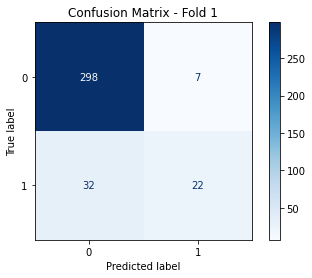


Fold 2 - ROC-AUC Train: 0.9872 | Val: 0.9000
Fold 2 - F1-Score Train:  0.8223 | Val: 0.5057
              precision    recall  f1-score   support

           0     0.9018    0.9639    0.9319       305
           1     0.6667    0.4074    0.5057        54

    accuracy                         0.8802       359
   macro avg     0.7843    0.6857    0.7188       359
weighted avg     0.8665    0.8802    0.8678       359



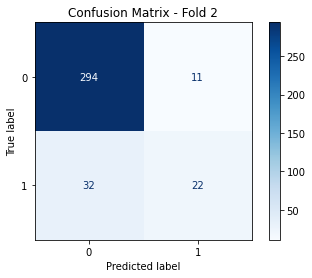


Fold 3 - ROC-AUC Train: 0.9864 | Val: 0.9211
Fold 3 - F1-Score Train:  0.7869 | Val: 0.4211
              precision    recall  f1-score   support

           0     0.8896    0.9770    0.9312       305
           1     0.6957    0.3019    0.4211        53

    accuracy                         0.8771       358
   macro avg     0.7926    0.6395    0.6762       358
weighted avg     0.8608    0.8771    0.8557       358



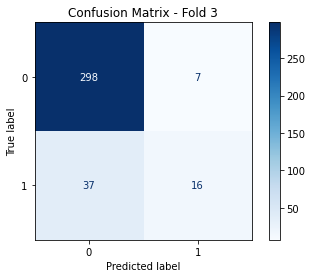


Fold 4 - ROC-AUC Train: 0.9869 | Val: 0.9223
Fold 4 - F1-Score Train:  0.8097 | Val: 0.4828
              precision    recall  f1-score   support

           0     0.9012    0.9574    0.9285       305
           1     0.6176    0.3962    0.4828        53

    accuracy                         0.8743       358
   macro avg     0.7594    0.6768    0.7056       358
weighted avg     0.8593    0.8743    0.8625       358



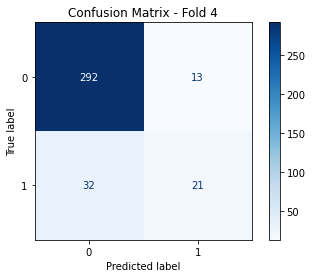


Fold 5 - ROC-AUC Train: 0.9874 | Val: 0.8701
Fold 5 - F1-Score Train:  0.8000 | Val: 0.5393
              precision    recall  f1-score   support

           0     0.9099    0.9607    0.9346       305
           1     0.6667    0.4528    0.5393        53

    accuracy                         0.8855       358
   macro avg     0.7883    0.7067    0.7370       358
weighted avg     0.8739    0.8855    0.8761       358



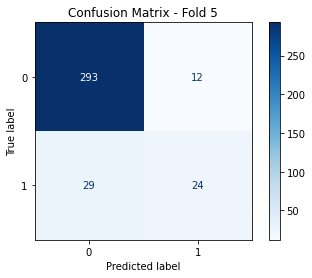


=== AVERAGE SCORES ===
ROC-AUC Train Avg: 0.9869 | Val Avg: 0.9053
F1-Score Train Avg: 0.8048 | Val Avg: 0.4958


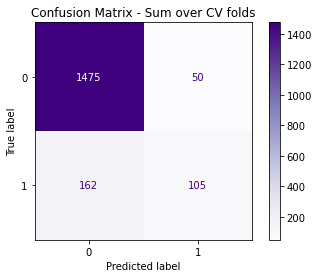

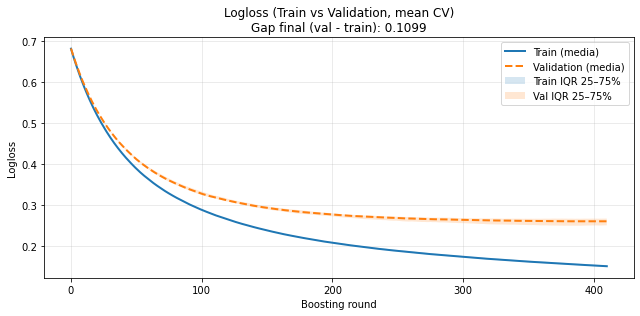

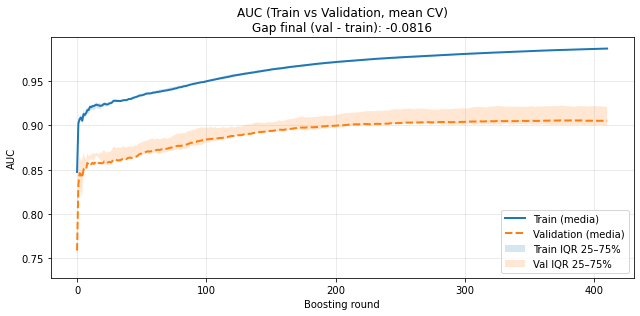

In [16]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
# Configurar los hiperparámetros
params = study.best_params
# =========================
# Validación cruzada
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_auc_scores, val_auc_scores = [], []
train_f1_scores,  val_f1_scores  = [], []
conf_mats = []  # matrices de confusión por fold

# Para curvas por iteración (boosting rounds)
train_logloss_curves, val_logloss_curves = [], []
train_auc_curves,     val_auc_curves     = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = XGBClassifier(**params,
        eval_metric=['logloss', 'auc'],
        tree_method='hist',
        enable_categorical=True,
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],  # train primero = validation_0
        verbose=False
        # early_stopping_rounds=50,               # OPCIONAL: si lo activas, las curvas tendrán distinta longitud
    )

    # -------- Predicciones y métricas por fold --------
    y_tr_pred  = model.predict(X_tr)
    y_tr_proba = model.predict_proba(X_tr)[:, 1]
    y_val_pred  = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    train_auc = roc_auc_score(y_tr, y_tr_proba)
    val_auc   = roc_auc_score(y_val, y_val_proba)
    train_f1  = f1_score(y_tr, y_tr_pred)
    val_f1    = f1_score(y_val, y_val_pred)

    train_auc_scores.append(train_auc);  val_auc_scores.append(val_auc)
    train_f1_scores.append(train_f1);    val_f1_scores.append(val_f1)

    print(f"\nFold {fold} - ROC-AUC Train: {train_auc:.4f} | Val: {val_auc:.4f}")
    print(f"Fold {fold} - F1-Score Train:  {train_f1:.4f} | Val: {val_f1:.4f}")
    print(classification_report(y_val, y_val_pred, digits=4))

    # -------- Matriz de confusión por fold --------
    cm = confusion_matrix(y_val, y_val_pred, labels=[0, 1])
    conf_mats.append(cm)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(values_format='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.show()

    # -------- Curvas por iteración (logloss y auc) --------
    evals = model.evals_result()
    # Claves: 'validation_0' = train, 'validation_1' = val
    train_logloss_curves.append(evals['validation_0']['logloss'])
    val_logloss_curves.append(evals['validation_1']['logloss'])
    train_auc_curves.append(evals['validation_0']['auc'])
    val_auc_curves.append(evals['validation_1']['auc'])

# =========================
# Agregados finales
# =========================
print("\n=== AVERAGE SCORES ===")
print(f"ROC-AUC Train Avg: {np.mean(train_auc_scores):.4f} | Val Avg: {np.mean(val_auc_scores):.4f}")
print(f"F1-Score Train Avg: {np.mean(train_f1_scores):.4f} | Val Avg: {np.mean(val_f1_scores):.4f}")

# Matriz de confusión agregada (suma de folds)
cm_sum = np.sum(conf_mats, axis=0)
disp = ConfusionMatrixDisplay(cm_sum, display_labels=[0, 1])
disp.plot(values_format='d', cmap='Purples')
plt.title('Confusion Matrix - Sum over CV folds')
plt.show()

# =========================
# Curvas de entrenamiento vs validación (promedio de folds)
# =========================
import numpy as np
import matplotlib.pyplot as plt

def _stack_curves(curves, max_len=None):
    """Recorta todas las listas a la misma longitud y apila en matriz."""
    if len(curves) == 0:
        raise ValueError("Lista de curvas vacía.")
    lens = [len(c) for c in curves]
    L = min(lens) if max_len is None else min(min(lens), max_len)
    M = np.vstack([np.asarray(c[:L], dtype=float) for c in curves])
    return M

def plot_train_val_curves(train_curves, val_curves, title, ylabel, as_error=False):
    """
    Dibuja en una misma figura la curva media (y banda IQR) de train y val.
    - train_curves/val_curves: listas de listas (una por fold)
    - as_error=True: usa 1 - métrica (útil para AUC -> error)
    """
    # Alinear longitudes
    min_len = min(min(len(c) for c in train_curves), min(len(c) for c in val_curves))
    T = _stack_curves(train_curves, max_len=min_len)
    V = _stack_curves(val_curves,   max_len=min_len)

    if as_error:
        T = 1.0 - T
        V = 1.0 - V

    # Estadísticos
    T_mean, T_p25, T_p75 = T.mean(axis=0), np.percentile(T, 25, axis=0), np.percentile(T, 75, axis=0)
    V_mean, V_p25, V_p75 = V.mean(axis=0), np.percentile(V, 25, axis=0), np.percentile(V, 75, axis=0)

    x = np.arange(min_len)

    plt.figure(figsize=(9, 4.5))
    # Train
    plt.plot(x, T_mean, label='Train (media)', linewidth=2)
    plt.fill_between(x, T_p25, T_p75, alpha=0.18, label='Train IQR 25–75%')
    # Val
    plt.plot(x, V_mean, label='Validation (media)', linewidth=2, linestyle='--')
    plt.fill_between(x, V_p25, V_p75, alpha=0.18, label='Val IQR 25–75%')

    # Gap como texto
    gap = (V_mean[-1] - T_mean[-1])
    plt.title(f"{title}\nGap final (val - train): {gap:.4f}")
    plt.xlabel('Boosting round')
    plt.ylabel(ylabel if not as_error else f"{ylabel} (error)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Llamadas ===
# 1) Logloss (más bajo es mejor)
plot_train_val_curves(train_logloss_curves, val_logloss_curves,
                      title='Logloss (Train vs Validation, mean CV)', ylabel='Logloss')

# 2) AUC (más alto es mejor)
plot_train_val_curves(train_auc_curves, val_auc_curves,
                      title='AUC (Train vs Validation, mean CV)', ylabel='AUC')

# (Opcional) si prefieres ver “error” en AUC, usa:
# plot_train_val_curves(train_auc_curves, val_auc_curves,
#                       title='1 - AUC (Train vs Validation, mean CV)', ylabel='1 - AUC', as_error=True)

### Second Tune

In [17]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import numpy as np
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


from sklearn.metrics import f1_score, roc_auc_score

def objective(trial):
    param = {
    'max_depth': trial.suggest_int('max_depth', 3, 10),  # límite inferior más conservador
    'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),  # tasa de aprendizaje más baja para evitar sobreajuste
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # más rondas posibles con early stopping

    # Regularización
    'min_child_weight': trial.suggest_int('min_child_weight', 3, 20),  # más peso mínimo por hoja → más robusto
    'gamma': trial.suggest_float('gamma', 0, 5),  # ganancia mínima para hacer split → evita divisiones innecesarias
    'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),  # regularización L1 (sparse)
    'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),  # regularización L2 (ridge)

    # Subsampling
    'subsample': trial.suggest_float('subsample', 0.5, 1),  # menos datos por árbol → menos dependencia
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),  # menos features por árbol

    # Otros
    'scale_pos_weight': scale_pos_weight,  # para balancear clases si están desbalanceadas
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42,
    'n_jobs': -1}
    
    model = XGBClassifier(tree_method='hist',enable_categorical=True,**param)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_val_scores = []
    f1_train_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=100,
            verbose=False
        )

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        f1_train = f1_score(y_tr, y_tr_pred)
        f1_val = f1_score(y_val, y_val_pred)

        f1_train_scores.append(f1_train)
        f1_val_scores.append(f1_val)

    # Penalización por overfitting
    train_mean = np.mean(f1_train_scores)
    val_mean = np.mean(f1_val_scores)
    overfit_penalty = abs(train_mean - val_mean)

    return val_mean - overfit_penalty * 0.5  # penaliza más si hay mucho overfitting



# ✅ Argumento corregido aquí
sampler = TPESampler(seed=42, multivariate=True, n_startup_trials=20)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

print("Best F1-Score:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-09-07 22:46:20,616] A new study created in memory with name: no-name-43bd9b9f-b7d2-4699-8191-32a0ceda69cf
[I 2025-09-07 22:46:22,331] Trial 0 finished with value: 0.46332412414365437 and parameters: {'max_depth': 5, 'learning_rate': 0.07969454818643935, 'n_estimators': 759, 'min_child_weight': 13, 'gamma': 0.7800932022121826, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124, 'subsample': 0.9330880728874675, 'colsample_bytree': 0.8005575058716043}. Best is trial 0 with value: 0.46332412414365437.
[I 2025-09-07 22:46:28,028] Trial 1 finished with value: 0.5200803127936086 and parameters: {'max_depth': 8, 'learning_rate': 0.0010994335574766201, 'n_estimators': 973, 'min_child_weight': 17, 'gamma': 1.0616955533913808, 'reg_alpha': 0.005337032762603957, 'reg_lambda': 0.00541524411940254, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119}. Best is trial 1 with value: 0.5200803127936086.
[I 2025-09-07 22:46:31,971] Trial 2 finished with value

[I 2025-09-07 22:47:07,603] Trial 20 finished with value: 0.5157229876681939 and parameters: {'max_depth': 3, 'learning_rate': 0.03160136235519566, 'n_estimators': 845, 'min_child_weight': 11, 'gamma': 3.1750024902511944, 'reg_alpha': 1.1539853851164292, 'reg_lambda': 0.3012427897779622, 'subsample': 0.7196614473402084, 'colsample_bytree': 0.5773212951933684}. Best is trial 15 with value: 0.544913370587829.
[I 2025-09-07 22:47:08,906] Trial 21 finished with value: 0.5421384521261452 and parameters: {'max_depth': 3, 'learning_rate': 0.007538613178222055, 'n_estimators': 335, 'min_child_weight': 17, 'gamma': 1.1485247798233813, 'reg_alpha': 0.390261651478388, 'reg_lambda': 0.14816031399904678, 'subsample': 0.924195669384488, 'colsample_bytree': 0.576059580174447}. Best is trial 15 with value: 0.544913370587829.
[I 2025-09-07 22:47:11,673] Trial 22 finished with value: 0.5357590108957486 and parameters: {'max_depth': 6, 'learning_rate': 0.009413682693122503, 'n_estimators': 664, 'min_chil

[I 2025-09-07 22:47:42,466] Trial 40 finished with value: 0.5280747546112834 and parameters: {'max_depth': 4, 'learning_rate': 0.004614201291898044, 'n_estimators': 450, 'min_child_weight': 7, 'gamma': 3.2666027709702825, 'reg_alpha': 2.2481791282780335, 'reg_lambda': 0.0016133921391179263, 'subsample': 0.967343362981277, 'colsample_bytree': 0.5443284335318239}. Best is trial 31 with value: 0.5511251987899822.
[I 2025-09-07 22:47:44,129] Trial 41 finished with value: 0.5029258432015715 and parameters: {'max_depth': 6, 'learning_rate': 0.044991835993465505, 'n_estimators': 705, 'min_child_weight': 3, 'gamma': 4.22780605356601, 'reg_alpha': 1.7651436045577922, 'reg_lambda': 0.010437275501627558, 'subsample': 0.9334078701437403, 'colsample_bytree': 0.6139420501366074}. Best is trial 31 with value: 0.5511251987899822.
[I 2025-09-07 22:47:46,321] Trial 42 finished with value: 0.5504635230835057 and parameters: {'max_depth': 6, 'learning_rate': 0.01693406456163015, 'n_estimators': 643, 'min_

[I 2025-09-07 22:48:09,876] Trial 60 finished with value: 0.5214418227902766 and parameters: {'max_depth': 4, 'learning_rate': 0.08378861601773607, 'n_estimators': 585, 'min_child_weight': 9, 'gamma': 2.4270080084902252, 'reg_alpha': 0.5091595480214571, 'reg_lambda': 0.0015425526611283378, 'subsample': 0.6485602724894057, 'colsample_bytree': 0.5972975512521534}. Best is trial 43 with value: 0.5562366680545479.
[I 2025-09-07 22:48:11,210] Trial 61 finished with value: 0.5498413878302051 and parameters: {'max_depth': 3, 'learning_rate': 0.010467827660415431, 'n_estimators': 354, 'min_child_weight': 14, 'gamma': 4.688921885777645, 'reg_alpha': 9.638809958677507, 'reg_lambda': 0.004945619110794778, 'subsample': 0.922063515655894, 'colsample_bytree': 0.7038629098641964}. Best is trial 43 with value: 0.5562366680545479.
[I 2025-09-07 22:48:13,167] Trial 62 finished with value: 0.5347534237035855 and parameters: {'max_depth': 4, 'learning_rate': 0.008890492805343318, 'n_estimators': 508, 'min

[I 2025-09-07 22:48:47,728] Trial 80 finished with value: 0.5546532941344874 and parameters: {'max_depth': 10, 'learning_rate': 0.03854943896741529, 'n_estimators': 566, 'min_child_weight': 16, 'gamma': 4.869823381897572, 'reg_alpha': 5.825283027552743, 'reg_lambda': 0.0075597165599585545, 'subsample': 0.8205006953630253, 'colsample_bytree': 0.9808347181010035}. Best is trial 72 with value: 0.5619176613040475.
[I 2025-09-07 22:48:49,372] Trial 81 finished with value: 0.5265930899431732 and parameters: {'max_depth': 9, 'learning_rate': 0.06879190150943301, 'n_estimators': 511, 'min_child_weight': 17, 'gamma': 4.900067759233663, 'reg_alpha': 2.6171461481919773, 'reg_lambda': 0.009183486980573585, 'subsample': 0.7515918650972946, 'colsample_bytree': 0.9217993426082575}. Best is trial 72 with value: 0.5619176613040475.
[I 2025-09-07 22:48:50,511] Trial 82 finished with value: 0.5222470543183555 and parameters: {'max_depth': 10, 'learning_rate': 0.05942146382507334, 'n_estimators': 207, 'mi

Best F1-Score: 0.5619176613040475
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.03958270702675378, 'n_estimators': 843, 'min_child_weight': 19, 'gamma': 4.334748017137544, 'reg_alpha': 5.042272045415784, 'reg_lambda': 0.031129922025562858, 'subsample': 0.8087116575765794, 'colsample_bytree': 0.758748694019102}


### XGBoost With 2ns Tune


Fold 1 - ROC-AUC Train: 0.9211 | Val: 0.8886
Fold 1 - F1-Score Train:  0.3717 | Val: 0.3636
              precision    recall  f1-score   support

           0     0.8790    1.0000    0.9356       305
           1     1.0000    0.2222    0.3636        54

    accuracy                         0.8830       359
   macro avg     0.9395    0.6111    0.6496       359
weighted avg     0.8972    0.8830    0.8496       359



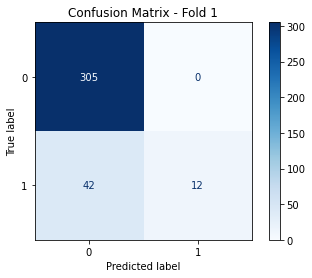


Fold 2 - ROC-AUC Train: 0.9167 | Val: 0.8760
Fold 2 - F1-Score Train:  0.4460 | Val: 0.2985
              precision    recall  f1-score   support

           0     0.8728    0.9902    0.9278       305
           1     0.7692    0.1852    0.2985        54

    accuracy                         0.8691       359
   macro avg     0.8210    0.5877    0.6132       359
weighted avg     0.8572    0.8691    0.8331       359



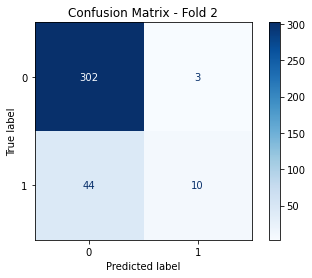


Fold 3 - ROC-AUC Train: 0.9111 | Val: 0.8800
Fold 3 - F1-Score Train:  0.3855 | Val: 0.2500
              precision    recall  f1-score   support

           0     0.8703    0.9902    0.9264       305
           1     0.7273    0.1509    0.2500        53

    accuracy                         0.8659       358
   macro avg     0.7988    0.5706    0.5882       358
weighted avg     0.8491    0.8659    0.8262       358



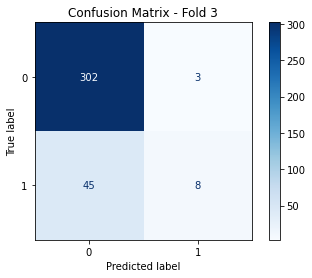


Fold 4 - ROC-AUC Train: 0.9155 | Val: 0.9085
Fold 4 - F1-Score Train:  0.4161 | Val: 0.2462
              precision    recall  f1-score   support

           0     0.8699    0.9869    0.9247       305
           1     0.6667    0.1509    0.2462        53

    accuracy                         0.8631       358
   macro avg     0.7683    0.5689    0.5854       358
weighted avg     0.8398    0.8631    0.8243       358



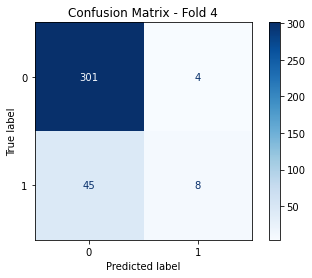


Fold 5 - ROC-AUC Train: 0.9268 | Val: 0.8440
Fold 5 - F1-Score Train:  0.4245 | Val: 0.4348
              precision    recall  f1-score   support

           0     0.8889    0.9967    0.9397       305
           1     0.9375    0.2830    0.4348        53

    accuracy                         0.8911       358
   macro avg     0.9132    0.6399    0.6873       358
weighted avg     0.8961    0.8911    0.8650       358



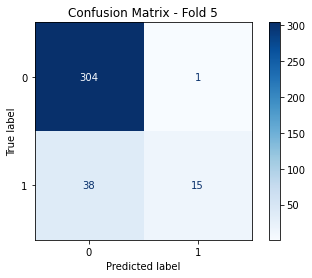


=== AVERAGE SCORES ===
ROC-AUC Train Avg: 0.9183 | Val Avg: 0.8794
F1-Score Train Avg: 0.4087 | Val Avg: 0.3186


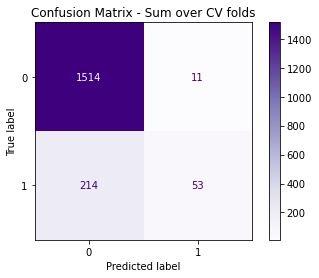

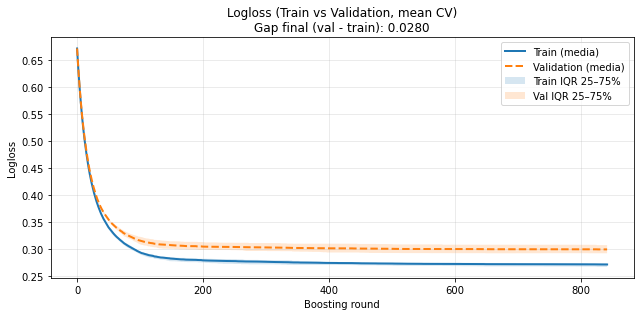

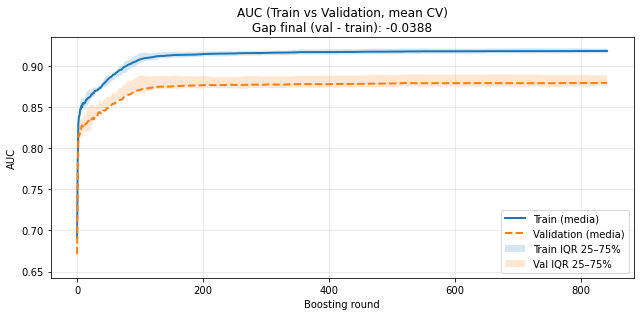

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
# Configurar los hiperparámetros
params = study.best_params
# =========================
# Validación cruzada
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_auc_scores, val_auc_scores = [], []
train_f1_scores,  val_f1_scores  = [], []
conf_mats = []  # matrices de confusión por fold

# Para curvas por iteración (boosting rounds)
train_logloss_curves, val_logloss_curves = [], []
train_auc_curves,     val_auc_curves     = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = XGBClassifier(**params,
        eval_metric=['logloss', 'auc'],
        tree_method='hist',
        enable_categorical=True,
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],  # train primero = validation_0
        verbose=False
        # early_stopping_rounds=50,               # OPCIONAL: si lo activas, las curvas tendrán distinta longitud
    )

    # -------- Predicciones y métricas por fold --------
    y_tr_pred  = model.predict(X_tr)
    y_tr_proba = model.predict_proba(X_tr)[:, 1]
    y_val_pred  = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    train_auc = roc_auc_score(y_tr, y_tr_proba)
    val_auc   = roc_auc_score(y_val, y_val_proba)
    train_f1  = f1_score(y_tr, y_tr_pred)
    val_f1    = f1_score(y_val, y_val_pred)

    train_auc_scores.append(train_auc);  val_auc_scores.append(val_auc)
    train_f1_scores.append(train_f1);    val_f1_scores.append(val_f1)

    print(f"\nFold {fold} - ROC-AUC Train: {train_auc:.4f} | Val: {val_auc:.4f}")
    print(f"Fold {fold} - F1-Score Train:  {train_f1:.4f} | Val: {val_f1:.4f}")
    print(classification_report(y_val, y_val_pred, digits=4))

    # -------- Matriz de confusión por fold --------
    cm = confusion_matrix(y_val, y_val_pred, labels=[0, 1])
    conf_mats.append(cm)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(values_format='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.show()

    # -------- Curvas por iteración (logloss y auc) --------
    evals = model.evals_result()
    # Claves: 'validation_0' = train, 'validation_1' = val
    train_logloss_curves.append(evals['validation_0']['logloss'])
    val_logloss_curves.append(evals['validation_1']['logloss'])
    train_auc_curves.append(evals['validation_0']['auc'])
    val_auc_curves.append(evals['validation_1']['auc'])

# =========================
# Agregados finales
# =========================
print("\n=== AVERAGE SCORES ===")
print(f"ROC-AUC Train Avg: {np.mean(train_auc_scores):.4f} | Val Avg: {np.mean(val_auc_scores):.4f}")
print(f"F1-Score Train Avg: {np.mean(train_f1_scores):.4f} | Val Avg: {np.mean(val_f1_scores):.4f}")

# Matriz de confusión agregada (suma de folds)
cm_sum = np.sum(conf_mats, axis=0)
disp = ConfusionMatrixDisplay(cm_sum, display_labels=[0, 1])
disp.plot(values_format='d', cmap='Purples')
plt.title('Confusion Matrix - Sum over CV folds')
plt.show()

# =========================
# Curvas de entrenamiento vs validación (promedio de folds)
# =========================
import numpy as np
import matplotlib.pyplot as plt

def _stack_curves(curves, max_len=None):
    """Recorta todas las listas a la misma longitud y apila en matriz."""
    if len(curves) == 0:
        raise ValueError("Lista de curvas vacía.")
    lens = [len(c) for c in curves]
    L = min(lens) if max_len is None else min(min(lens), max_len)
    M = np.vstack([np.asarray(c[:L], dtype=float) for c in curves])
    return M

def plot_train_val_curves(train_curves, val_curves, title, ylabel, as_error=False):
    """
    Dibuja en una misma figura la curva media (y banda IQR) de train y val.
    - train_curves/val_curves: listas de listas (una por fold)
    - as_error=True: usa 1 - métrica (útil para AUC -> error)
    """
    # Alinear longitudes
    min_len = min(min(len(c) for c in train_curves), min(len(c) for c in val_curves))
    T = _stack_curves(train_curves, max_len=min_len)
    V = _stack_curves(val_curves,   max_len=min_len)

    if as_error:
        T = 1.0 - T
        V = 1.0 - V

    # Estadísticos
    T_mean, T_p25, T_p75 = T.mean(axis=0), np.percentile(T, 25, axis=0), np.percentile(T, 75, axis=0)
    V_mean, V_p25, V_p75 = V.mean(axis=0), np.percentile(V, 25, axis=0), np.percentile(V, 75, axis=0)

    x = np.arange(min_len)

    plt.figure(figsize=(9, 4.5))
    # Train
    plt.plot(x, T_mean, label='Train (media)', linewidth=2)
    plt.fill_between(x, T_p25, T_p75, alpha=0.18, label='Train IQR 25–75%')
    # Val
    plt.plot(x, V_mean, label='Validation (media)', linewidth=2, linestyle='--')
    plt.fill_between(x, V_p25, V_p75, alpha=0.18, label='Val IQR 25–75%')

    # Gap como texto
    gap = (V_mean[-1] - T_mean[-1])
    plt.title(f"{title}\nGap final (val - train): {gap:.4f}")
    plt.xlabel('Boosting round')
    plt.ylabel(ylabel if not as_error else f"{ylabel} (error)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Llamadas ===
# 1) Logloss (más bajo es mejor)
plot_train_val_curves(train_logloss_curves, val_logloss_curves,
                      title='Logloss (Train vs Validation, mean CV)', ylabel='Logloss')

# 2) AUC (más alto es mejor)
plot_train_val_curves(train_auc_curves, val_auc_curves,
                      title='AUC (Train vs Validation, mean CV)', ylabel='AUC')

# (Opcional) si prefieres ver “error” en AUC, usa:
# plot_train_val_curves(train_auc_curves, val_auc_curves,
#                       title='1 - AUC (Train vs Validation, mean CV)', ylabel='1 - AUC', as_error=True)

### 3er Tune

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import numpy as np
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


from sklearn.metrics import f1_score, roc_auc_score

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),  # más largo
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': scale_pos_weight,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBClassifier(tree_method='hist',enable_categorical=True,**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=100,
            verbose=False
        )

        y_val_pred = model.predict(X_val)
        val_f1_scores.append(f1_score(y_val, y_val_pred))

    return np.mean(val_f1_scores)  # SIN penalización por overfitting



# ✅ Argumento corregido aquí
sampler = TPESampler(seed=42, multivariate=True, n_startup_trials=20)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

print("Best F1-Score:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-09-07 22:49:27,916] A new study created in memory with name: no-name-6a5eedc3-a16f-4429-bea3-78b8cf16ae17
[I 2025-09-07 22:49:29,232] Trial 0 finished with value: 0.6271395158709041 and parameters: {'max_depth': 5, 'learning_rate': 0.07969454818643935, 'n_estimators': 1179, 'min_child_weight': 6, 'gamma': 0.7800932022121826, 'reg_alpha': 0.000602521573620386, 'reg_lambda': 0.00019517224641449495, 'subsample': 0.9330880728874675, 'colsample_bytree': 0.8005575058716043}. Best is trial 0 with value: 0.6271395158709041.
[I 2025-09-07 22:49:37,724] Trial 1 finished with value: 0.5982165482631037 and parameters: {'max_depth': 8, 'learning_rate': 0.0010994335574766201, 'n_estimators': 1464, 'min_child_weight': 9, 'gamma': 1.0616955533913808, 'reg_alpha': 0.0008111941985431928, 'reg_lambda': 0.0008260808399079611, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119}. Best is trial 0 with value: 0.6271395158709041.
[I 2025-09-07 22:49:43,217] Trial 2 finished with val

[I 2025-09-07 22:50:35,589] Trial 20 finished with value: 0.6274990917176048 and parameters: {'max_depth': 4, 'learning_rate': 0.058588815892153465, 'n_estimators': 737, 'min_child_weight': 10, 'gamma': 4.631086872777139, 'reg_alpha': 0.26867913866598747, 'reg_lambda': 0.00016853241643918372, 'subsample': 0.7338028882455129, 'colsample_bytree': 0.7757315311229472}. Best is trial 13 with value: 0.6279928892576512.
[I 2025-09-07 22:50:37,866] Trial 21 finished with value: 0.623946203776554 and parameters: {'max_depth': 3, 'learning_rate': 0.032029254578039165, 'n_estimators': 750, 'min_child_weight': 10, 'gamma': 4.19792507684374, 'reg_alpha': 0.16489035966179302, 'reg_lambda': 0.0022204300250764143, 'subsample': 0.7413875238344585, 'colsample_bytree': 0.7432665907813348}. Best is trial 13 with value: 0.6279928892576512.
[I 2025-09-07 22:50:39,451] Trial 22 finished with value: 0.6326994216643762 and parameters: {'max_depth': 7, 'learning_rate': 0.04757785550090289, 'n_estimators': 558, 

[I 2025-09-07 22:51:16,279] Trial 40 finished with value: 0.6277815168190874 and parameters: {'max_depth': 9, 'learning_rate': 0.06588574923963024, 'n_estimators': 566, 'min_child_weight': 8, 'gamma': 4.755696392015257, 'reg_alpha': 0.00010054631130397887, 'reg_lambda': 0.7816637675272611, 'subsample': 0.655161790063912, 'colsample_bytree': 0.722351843548385}. Best is trial 24 with value: 0.6368868401602675.
[I 2025-09-07 22:51:19,141] Trial 41 finished with value: 0.6184351825024419 and parameters: {'max_depth': 5, 'learning_rate': 0.022077431178900677, 'n_estimators': 1188, 'min_child_weight': 9, 'gamma': 3.151687686984562, 'reg_alpha': 0.074005890805362, 'reg_lambda': 0.002462007826218153, 'subsample': 0.5152344896693651, 'colsample_bytree': 0.9180496525788582}. Best is trial 24 with value: 0.6368868401602675.
[I 2025-09-07 22:51:21,296] Trial 42 finished with value: 0.6120111670223363 and parameters: {'max_depth': 5, 'learning_rate': 0.028165367005017383, 'n_estimators': 713, 'min_

[I 2025-09-07 22:52:08,589] Trial 60 finished with value: 0.6285604723017262 and parameters: {'max_depth': 8, 'learning_rate': 0.008870920596027624, 'n_estimators': 1395, 'min_child_weight': 10, 'gamma': 1.7299900450840906, 'reg_alpha': 0.008104256794628034, 'reg_lambda': 0.00123814814891133, 'subsample': 0.8128854375268407, 'colsample_bytree': 0.6273521793209442}. Best is trial 55 with value: 0.6409712347277345.
[I 2025-09-07 22:52:10,930] Trial 61 finished with value: 0.6439817905130095 and parameters: {'max_depth': 9, 'learning_rate': 0.02541514954031589, 'n_estimators': 1068, 'min_child_weight': 8, 'gamma': 1.4937328840945998, 'reg_alpha': 0.16734582492050107, 'reg_lambda': 0.0002489495228303031, 'subsample': 0.884119265397473, 'colsample_bytree': 0.6998390701710762}. Best is trial 61 with value: 0.6439817905130095.
[I 2025-09-07 22:52:13,055] Trial 62 finished with value: 0.6169219189862242 and parameters: {'max_depth': 9, 'learning_rate': 0.026992681729804208, 'n_estimators': 127

[I 2025-09-07 22:52:48,385] Trial 80 finished with value: 0.616469447658077 and parameters: {'max_depth': 6, 'learning_rate': 0.033202558999795934, 'n_estimators': 596, 'min_child_weight': 10, 'gamma': 4.6754200007960405, 'reg_alpha': 0.00024582605729231975, 'reg_lambda': 0.08764349452989136, 'subsample': 0.7768993573215649, 'colsample_bytree': 0.7576474007762666}. Best is trial 61 with value: 0.6439817905130095.
[I 2025-09-07 22:52:49,567] Trial 81 finished with value: 0.6100755153154405 and parameters: {'max_depth': 9, 'learning_rate': 0.09317073391686184, 'n_estimators': 376, 'min_child_weight': 10, 'gamma': 4.583448378353765, 'reg_alpha': 0.0017088115903242864, 'reg_lambda': 0.054956278482569856, 'subsample': 0.7484053796622384, 'colsample_bytree': 0.6924318260196363}. Best is trial 61 with value: 0.6439817905130095.
[I 2025-09-07 22:52:51,042] Trial 82 finished with value: 0.6172336306312391 and parameters: {'max_depth': 4, 'learning_rate': 0.07655451851811279, 'n_estimators': 968

Best F1-Score: 0.6439817905130095
Best hyperparameters: {'max_depth': 9, 'learning_rate': 0.02541514954031589, 'n_estimators': 1068, 'min_child_weight': 8, 'gamma': 1.4937328840945998, 'reg_alpha': 0.16734582492050107, 'reg_lambda': 0.0002489495228303031, 'subsample': 0.884119265397473, 'colsample_bytree': 0.6998390701710762}


### XGBoost With 3rd Tune


Fold 1 - ROC-AUC Train: 0.9901 | Val: 0.9166
Fold 1 - F1-Score Train:  0.8263 | Val: 0.5476
              precision    recall  f1-score   support

           0     0.9058    0.9770    0.9401       305
           1     0.7667    0.4259    0.5476        54

    accuracy                         0.8942       359
   macro avg     0.8362    0.7015    0.7438       359
weighted avg     0.8849    0.8942    0.8810       359



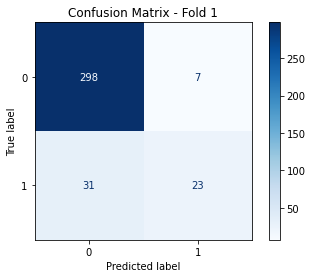


Fold 2 - ROC-AUC Train: 0.9892 | Val: 0.9062
Fold 2 - F1-Score Train:  0.8251 | Val: 0.5057
              precision    recall  f1-score   support

           0     0.9018    0.9639    0.9319       305
           1     0.6667    0.4074    0.5057        54

    accuracy                         0.8802       359
   macro avg     0.7843    0.6857    0.7188       359
weighted avg     0.8665    0.8802    0.8678       359



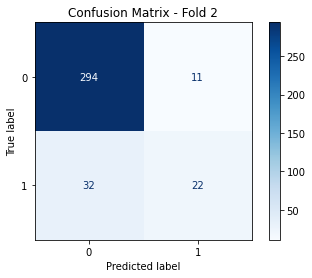


Fold 3 - ROC-AUC Train: 0.9888 | Val: 0.9208
Fold 3 - F1-Score Train:  0.8468 | Val: 0.4750
              precision    recall  f1-score   support

           0     0.8973    0.9738    0.9340       305
           1     0.7037    0.3585    0.4750        53

    accuracy                         0.8827       358
   macro avg     0.8005    0.6661    0.7045       358
weighted avg     0.8686    0.8827    0.8660       358



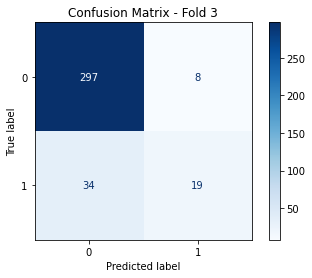


Fold 4 - ROC-AUC Train: 0.9895 | Val: 0.9260
Fold 4 - F1-Score Train:  0.8338 | Val: 0.5287
              precision    recall  f1-score   support

           0     0.9074    0.9639    0.9348       305
           1     0.6765    0.4340    0.5287        53

    accuracy                         0.8855       358
   macro avg     0.7919    0.6989    0.7318       358
weighted avg     0.8732    0.8855    0.8747       358



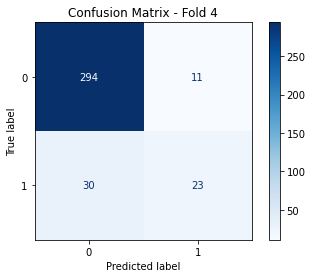


Fold 5 - ROC-AUC Train: 0.9907 | Val: 0.8813
Fold 5 - F1-Score Train:  0.8483 | Val: 0.5618
              precision    recall  f1-score   support

           0     0.9130    0.9639    0.9378       305
           1     0.6944    0.4717    0.5618        53

    accuracy                         0.8911       358
   macro avg     0.8037    0.7178    0.7498       358
weighted avg     0.8807    0.8911    0.8821       358



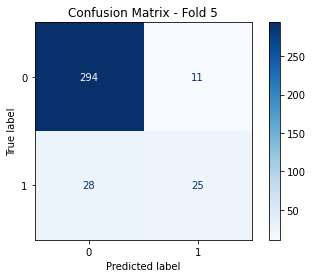


=== AVERAGE SCORES ===
ROC-AUC Train Avg: 0.9897 | Val Avg: 0.9102
F1-Score Train Avg: 0.8360 | Val Avg: 0.5238


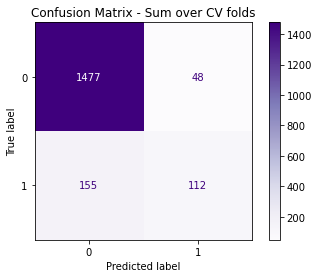

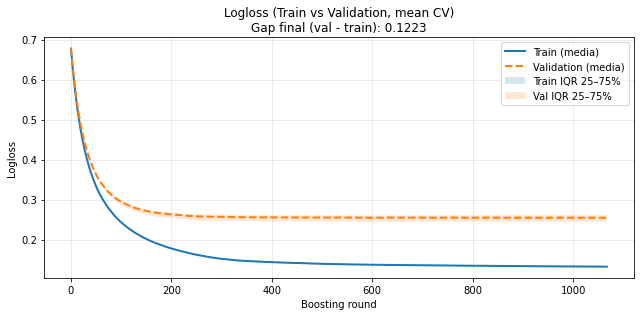

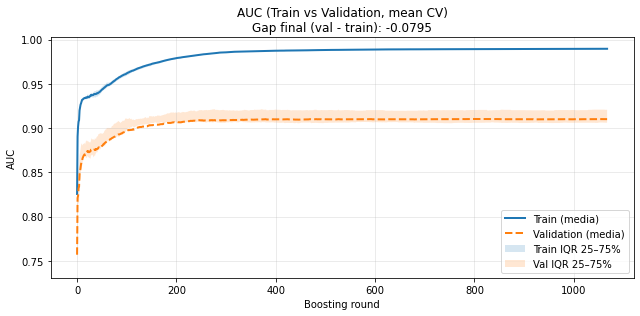

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
# Configurar los hiperparámetros
params = study.best_params
# =========================
# Validación cruzada
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_auc_scores, val_auc_scores = [], []
train_f1_scores,  val_f1_scores  = [], []
conf_mats = []  # matrices de confusión por fold

# Para curvas por iteración (boosting rounds)
train_logloss_curves, val_logloss_curves = [], []
train_auc_curves,     val_auc_curves     = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = XGBClassifier(**params,
        eval_metric=['logloss', 'auc'],
        tree_method='hist',
        enable_categorical=True,
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],  # train primero = validation_0
        verbose=False
        # early_stopping_rounds=50,               # OPCIONAL: si lo activas, las curvas tendrán distinta longitud
    )

    # -------- Predicciones y métricas por fold --------
    y_tr_pred  = model.predict(X_tr)
    y_tr_proba = model.predict_proba(X_tr)[:, 1]
    y_val_pred  = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    train_auc = roc_auc_score(y_tr, y_tr_proba)
    val_auc   = roc_auc_score(y_val, y_val_proba)
    train_f1  = f1_score(y_tr, y_tr_pred)
    val_f1    = f1_score(y_val, y_val_pred)

    train_auc_scores.append(train_auc);  val_auc_scores.append(val_auc)
    train_f1_scores.append(train_f1);    val_f1_scores.append(val_f1)

    print(f"\nFold {fold} - ROC-AUC Train: {train_auc:.4f} | Val: {val_auc:.4f}")
    print(f"Fold {fold} - F1-Score Train:  {train_f1:.4f} | Val: {val_f1:.4f}")
    print(classification_report(y_val, y_val_pred, digits=4))

    # -------- Matriz de confusión por fold --------
    cm = confusion_matrix(y_val, y_val_pred, labels=[0, 1])
    conf_mats.append(cm)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(values_format='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.show()

    # -------- Curvas por iteración (logloss y auc) --------
    evals = model.evals_result()
    # Claves: 'validation_0' = train, 'validation_1' = val
    train_logloss_curves.append(evals['validation_0']['logloss'])
    val_logloss_curves.append(evals['validation_1']['logloss'])
    train_auc_curves.append(evals['validation_0']['auc'])
    val_auc_curves.append(evals['validation_1']['auc'])

# =========================
# Agregados finales
# =========================
print("\n=== AVERAGE SCORES ===")
print(f"ROC-AUC Train Avg: {np.mean(train_auc_scores):.4f} | Val Avg: {np.mean(val_auc_scores):.4f}")
print(f"F1-Score Train Avg: {np.mean(train_f1_scores):.4f} | Val Avg: {np.mean(val_f1_scores):.4f}")

# Matriz de confusión agregada (suma de folds)
cm_sum = np.sum(conf_mats, axis=0)
disp = ConfusionMatrixDisplay(cm_sum, display_labels=[0, 1])
disp.plot(values_format='d', cmap='Purples')
plt.title('Confusion Matrix - Sum over CV folds')
plt.show()

# =========================
# Curvas de entrenamiento vs validación (promedio de folds)
# =========================
import numpy as np
import matplotlib.pyplot as plt

def _stack_curves(curves, max_len=None):
    """Recorta todas las listas a la misma longitud y apila en matriz."""
    if len(curves) == 0:
        raise ValueError("Lista de curvas vacía.")
    lens = [len(c) for c in curves]
    L = min(lens) if max_len is None else min(min(lens), max_len)
    M = np.vstack([np.asarray(c[:L], dtype=float) for c in curves])
    return M

def plot_train_val_curves(train_curves, val_curves, title, ylabel, as_error=False):
    """
    Dibuja en una misma figura la curva media (y banda IQR) de train y val.
    - train_curves/val_curves: listas de listas (una por fold)
    - as_error=True: usa 1 - métrica (útil para AUC -> error)
    """
    # Alinear longitudes
    min_len = min(min(len(c) for c in train_curves), min(len(c) for c in val_curves))
    T = _stack_curves(train_curves, max_len=min_len)
    V = _stack_curves(val_curves,   max_len=min_len)

    if as_error:
        T = 1.0 - T
        V = 1.0 - V

    # Estadísticos
    T_mean, T_p25, T_p75 = T.mean(axis=0), np.percentile(T, 25, axis=0), np.percentile(T, 75, axis=0)
    V_mean, V_p25, V_p75 = V.mean(axis=0), np.percentile(V, 25, axis=0), np.percentile(V, 75, axis=0)

    x = np.arange(min_len)

    plt.figure(figsize=(9, 4.5))
    # Train
    plt.plot(x, T_mean, label='Train (media)', linewidth=2)
    plt.fill_between(x, T_p25, T_p75, alpha=0.18, label='Train IQR 25–75%')
    # Val
    plt.plot(x, V_mean, label='Validation (media)', linewidth=2, linestyle='--')
    plt.fill_between(x, V_p25, V_p75, alpha=0.18, label='Val IQR 25–75%')

    # Gap como texto
    gap = (V_mean[-1] - T_mean[-1])
    plt.title(f"{title}\nGap final (val - train): {gap:.4f}")
    plt.xlabel('Boosting round')
    plt.ylabel(ylabel if not as_error else f"{ylabel} (error)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Llamadas ===
# 1) Logloss (más bajo es mejor)
plot_train_val_curves(train_logloss_curves, val_logloss_curves,
                      title='Logloss (Train vs Validation, mean CV)', ylabel='Logloss')

# 2) AUC (más alto es mejor)
plot_train_val_curves(train_auc_curves, val_auc_curves,
                      title='AUC (Train vs Validation, mean CV)', ylabel='AUC')

# (Opcional) si prefieres ver “error” en AUC, usa:
# plot_train_val_curves(train_auc_curves, val_auc_curves,
#                       title='1 - AUC (Train vs Validation, mean CV)', ylabel='1 - AUC', as_error=True)

### Threshold Tune Iterativo


 Mejor Threshold: 0.3769 con F1-Score: 0.8932

 Reporte de clasificación con threshold óptimo:
              precision    recall  f1-score   support

           0     0.9773    0.9869    0.9821       305
           1     0.9200    0.8679    0.8932        53

    accuracy                         0.9693       358
   macro avg     0.9486    0.9274    0.9376       358
weighted avg     0.9688    0.9693    0.9689       358



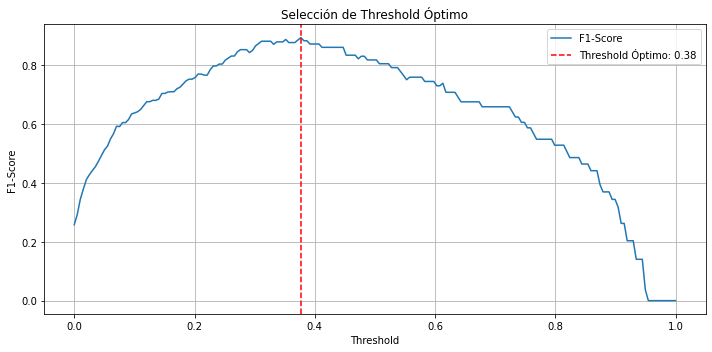

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, classification_report
from xgboost import XGBClassifier

# Entrena el modelo con los mejores parámetros
model = XGBClassifier(tree_method='hist',enable_categorical=True,**study.best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Probabilidades en validación
y_val_proba = model.predict_proba(X_val)[:, 1]

# ========= Buscar el threshold óptimo =========
thresholds = np.linspace(0.0, 1.0, 200)
f1_scores = []

for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    f1_scores.append(f1)

# Mejor threshold
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"\n Mejor Threshold: {best_threshold:.4f} con F1-Score: {best_f1:.4f}")

# ========= Reporte final con el mejor threshold =========
y_val_final_pred = (y_val_proba >= best_threshold).astype(int)
print("\n Reporte de clasificación con threshold óptimo:")
print(classification_report(y_val, y_val_final_pred, digits=4))

# ========= Curva para visualización =========
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Threshold Óptimo: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('Selección de Threshold Óptimo')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Threshold Tune Curva PR

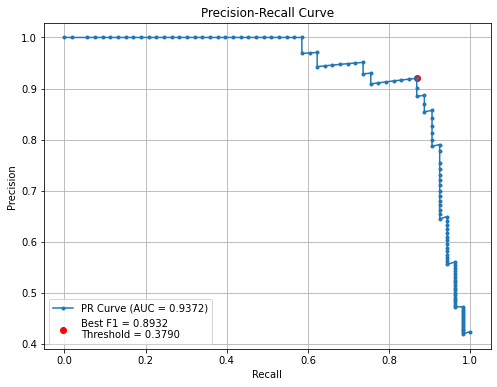


Mejor threshold según F1: 0.3790 con F1-score: 0.8932

Reporte de clasificación con threshold óptimo:
              precision    recall  f1-score   support

           0     0.9773    0.9869    0.9821       305
           1     0.9200    0.8679    0.8932        53

    accuracy                         0.9693       358
   macro avg     0.9486    0.9274    0.9376       358
weighted avg     0.9688    0.9693    0.9689       358



In [22]:
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, auc
import matplotlib.pyplot as plt
import numpy as np

# Paso 1: Obtener las probabilidades del modelo (ej: para validación)
y_val_proba = model.predict_proba(X_val)[:, 1]

# Paso 2: Calcular curva PR
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
pr_auc = auc(recall, precision)

# Paso 3: Calcular F1 para cada threshold (omitiendo el último porque no tiene threshold asociado)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Paso 4: Graficar la curva PR
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.scatter(recall[best_idx], precision[best_idx], marker='o', color='red', label=f'Best F1 = {best_f1:.4f}\nThreshold = {best_threshold:.4f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Paso 5: Clasificación con threshold óptimo
y_val_pred = (y_val_proba >= best_threshold).astype(int)
print(f"\nMejor threshold según F1: {best_threshold:.4f} con F1-score: {best_f1:.4f}")
print("\nReporte de clasificación con threshold óptimo:")
print(classification_report(y_val, y_val_pred, digits=4))

## 4. Explain model predictions with SHAP

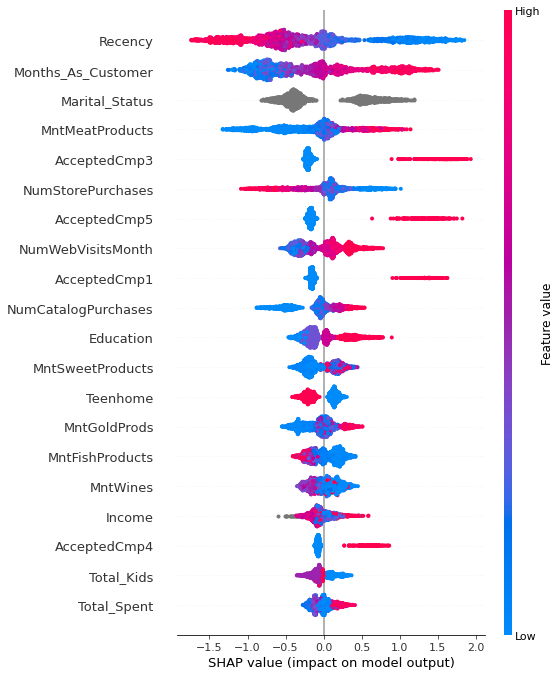

In [23]:
# Better model SHAP
model.fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)
plt.show()

## 5. Calibration Proof

### Reliability plot

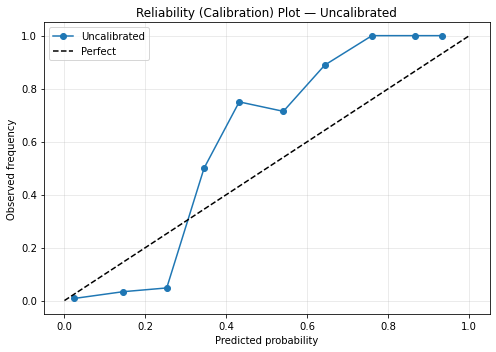

In [24]:
# === Reliability plot (modelo SIN calibrar) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 1) Elegir set de validación
if 'X_val' in globals() and 'y_val' in globals():
    Xtr, ytr = X_train, y_train
    Xva, yva = X_val, y_val
elif 'X_test' in globals() and 'y_test' in globals():
    Xtr, ytr = X_train, y_train
    Xva, yva = X_test, y_test
else:
    Xtr, Xva, ytr, yva = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

# 2) Modelo base (usa tus hiperparámetros si tienes 'study.best_params')
xgb_params = study.best_params

if 'study' in globals() and hasattr(study, 'best_params'):
    xgb_params.update(study.best_params)

model = XGBClassifier(**params,
        eval_metric=['logloss', 'auc'],
        tree_method='hist',
        enable_categorical=True,
    )
model.fit(Xtr, ytr)

# 3) Probabilidades sin calibrar y curva
p_uncal = model.predict_proba(Xva)[:, 1]
frac_pos, mean_pred = calibration_curve(yva, p_uncal, n_bins=10, strategy='uniform')

# 4) Plot
plt.figure(figsize=(7,5))
plt.plot(mean_pred, frac_pos, marker='o', label='Uncalibrated')
plt.plot([0,1],[0,1],'k--', label='Perfect')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Reliability (Calibration) Plot — Uncalibrated')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Preprocesing Calibrate

In [25]:
# === Fit base model and produce uncalibrated & calibrated probabilities (OOF calibration, no leakage) ===
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from xgboost import XGBClassifier

# ---------- helper: robust dtype preparation for XGBoost with categoricals ----------
def prepare_for_xgb(X: pd.DataFrame) -> pd.DataFrame:
    Xp = X.copy()

    # Datetime -> días desde época
    dt_cols = Xp.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns
    for c in dt_cols:
        Xp[c] = (Xp[c].view("int64") // 10**9) / 86400.0

    # Numéricas: imputación mediana
    num_cols = Xp.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        Xp[num_cols] = Xp[num_cols].fillna(Xp[num_cols].median())

    # Categóricas: asegurar dtype 'category' + categoría de missing
    obj_cols = Xp.select_dtypes(include=["object"]).columns.tolist()
    cat_cols = list(Xp.select_dtypes(include=["category"]).columns) + obj_cols
    for c in cat_cols:
        Xp[c] = Xp[c].astype("category")
        if Xp[c].isna().any():
            Xp[c] = Xp[c].cat.add_categories(["__MISSING__"]).fillna("__MISSING__")
    return Xp

# ---------- elegir set de validación ----------
if 'X_val' in globals() and 'y_val' in globals():
    Xtr_raw, ytr = X_train, y_train
    Xva_raw, yva = X_val, y_val
elif 'X_test' in globals() and 'y_test' in globals():
    Xtr_raw, ytr = X_train, y_train
    Xva_raw, yva = X_test, y_test
else:
    Xtr_raw, Xva_raw, ytr, yva = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

# Preparar dtypes
Xtr = prepare_for_xgb(Xtr_raw)
Xva = prepare_for_xgb(Xva_raw)

# ---------- hiperparámetros base (mezcla con los de tu estudio si existen) ----------
xgb_params = study.best_params
if 'study' in globals() and hasattr(study, 'best_params'):
    xgb_params.update(study.best_params)

# ---------- OOF predictions en TRAIN para calibración ----------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_pred = np.zeros(len(ytr), dtype=float)

for tr_idx, te_idx in skf.split(Xtr, ytr):
    Xm_tr, Xm_te = Xtr.iloc[tr_idx], Xtr.iloc[te_idx]
    ym_tr        = ytr.iloc[tr_idx]

    model_cv = XGBClassifier(**params,
        eval_metric=['logloss', 'auc'],
        tree_method='hist',
        enable_categorical=True,
    )
    model_cv.fit(Xm_tr, ym_tr)
    oof_pred[te_idx] = model_cv.predict_proba(Xm_te)[:, 1]

# ---------- Calibradores (Platt y Isotónico) entrenados sobre OOF ----------
def logit_clip(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# Platt (sigmoid)
platt_lr = LogisticRegression(solver='lbfgs')
platt_lr.fit(logit_clip(oof_pred).reshape(-1, 1), ytr)

def calibrate_sigmoid(p):
    z = logit_clip(p).reshape(-1, 1)
    return platt_lr.predict_proba(z)[:, 1]

# Isotonic
iso = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds='clip')
iso.fit(oof_pred, ytr)

def calibrate_isotonic(p):
    return iso.predict(p)

# ---------- Reentrenar modelo en TODO el TRAIN y evaluar en VALIDACIÓN ----------
base_model_full  = XGBClassifier(**params,
        eval_metric=['logloss', 'auc'],
        tree_method='hist',
        enable_categorical=True,
    )
base_model_full.fit(Xtr, ytr)

p_uncal = base_model_full.predict_proba(Xva)[:, 1]
p_sig   = calibrate_sigmoid(p_uncal)
p_iso   = calibrate_isotonic(p_uncal)

print("Ready (OOF calibration): p_uncal, p_sig, p_iso, yva")



Ready (OOF calibration): p_uncal, p_sig, p_iso, yva


###  Reliability plot with bin sizes (uncalibrated only) 


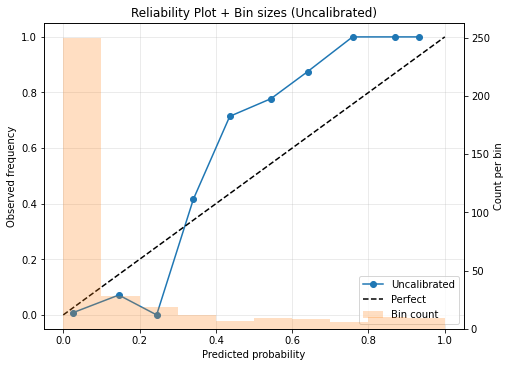

In [26]:
n_bins = 10
frac_pos, mean_pred = calibration_curve(yva, p_uncal, n_bins=n_bins, strategy='uniform')

# Build fixed uniform bins to count how many samples fall in each bin
edges = np.linspace(0, 1, n_bins + 1)
inds = np.digitize(p_uncal, edges[1:-1], right=False)
bin_counts = np.array([(inds == b).sum() for b in range(n_bins)])
bin_centers = 0.5 * (edges[:-1] + edges[1:])

fig, ax1 = plt.subplots(figsize=(7.2, 5.2))

# Reliability line
ax1.plot(mean_pred, frac_pos, marker='o', label='Uncalibrated', color='C0')
ax1.plot([0,1], [0,1], 'k--', label='Perfect')
ax1.set_xlabel('Predicted probability')
ax1.set_ylabel('Observed frequency')
ax1.set_title('Reliability Plot + Bin sizes (Uncalibrated)')
ax1.grid(alpha=0.3)

# Secondary axis for bin counts
ax2 = ax1.twinx()
ax2.bar(bin_centers, bin_counts, width=edges[1]-edges[0], alpha=0.25, color='C1', label='Bin count')
ax2.set_ylabel('Count per bin')

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc='lower right')

plt.tight_layout()
plt.show()


###  Bootstrap CIs for reliability curve (uncalibrated) 

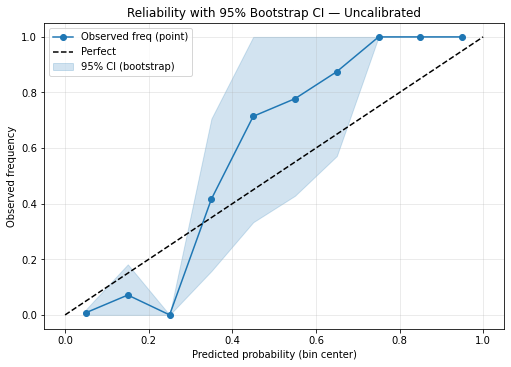

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Asegurar arrays 1D (posicionales)
yva_arr = np.asarray(yva).ravel()
p_uncal_arr = np.asarray(p_uncal).ravel()

n = len(yva_arr)
assert len(p_uncal_arr) == n, "p_uncal y yva deben tener el mismo largo."

B = 1000               # nº de remuestreos bootstrap
n_bins = 10
edges = np.linspace(0, 1, n_bins + 1)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

def obs_freq_per_bin(p, y, edges):
    """Frecuencia observada por bin (binned reliability) usando bins fijos uniformes."""
    inds = np.digitize(p, edges[1:-1], right=False)
    fr = np.full(len(edges) - 1, np.nan)
    for b in range(len(edges) - 1):
        idx = (inds == b)
        if np.any(idx):
            fr[b] = y[idx].mean()
    return fr

# Estimación puntual
point_freq = obs_freq_per_bin(p_uncal_arr, yva_arr, edges)

# Bootstrap (ojo: usamos arrays numpy, no Series)
rng = np.random.default_rng(42)
boot_mat = np.full((B, len(edges) - 1), np.nan)
idx_all = np.arange(n)

for b in range(B):
    sample_idx = rng.choice(idx_all, size=n, replace=True)
    boot_mat[b, :] = obs_freq_per_bin(p_uncal_arr[sample_idx], yva_arr[sample_idx], edges)

low = np.nanpercentile(boot_mat, 2.5, axis=0)
high = np.nanpercentile(boot_mat, 97.5, axis=0)

# Plot con ICs
plt.figure(figsize=(7.2, 5.2))
plt.plot(bin_centers, point_freq, marker='o', color='C0', label='Observed freq (point)')
plt.fill_between(bin_centers, low, high, color='C0', alpha=0.2, label='95% CI (bootstrap)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
plt.xlabel('Predicted probability (bin center)')
plt.ylabel('Observed frequency')
plt.title('Reliability with 95% Bootstrap CI — Uncalibrated')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Overlay: Uncalibrated vs Calibrated (sigmoid & isotonic) 


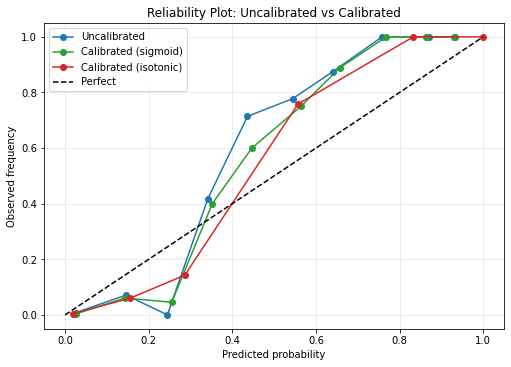

In [28]:
n_bins = 10
frac_u, mean_u = calibration_curve(yva, p_uncal, n_bins=n_bins, strategy='uniform')
frac_s, mean_s = calibration_curve(yva, p_sig,   n_bins=n_bins, strategy='uniform')
frac_i, mean_i = calibration_curve(yva, p_iso,   n_bins=n_bins, strategy='uniform')

plt.figure(figsize=(7.2, 5.2))
plt.plot(mean_u, frac_u, marker='o', label='Uncalibrated', color='C0')
plt.plot(mean_s, frac_s, marker='o', label='Calibrated (sigmoid)', color='C2')
plt.plot(mean_i, frac_i, marker='o', label='Calibrated (isotonic)', color='C3')
plt.plot([0,1], [0,1], 'k--', label='Perfect')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Reliability Plot: Uncalibrated vs Calibrated')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Numeric summary of calibration metrics 


[F1 criterion]  Best threshold: 0.3489 | F1: 0.8750
              precision    recall  f1-score   support

           0     0.9866    0.9639    0.9751       305
           1     0.8167    0.9245    0.8673        53

    accuracy                         0.9581       358
   macro avg     0.9016    0.9442    0.9212       358
weighted avg     0.9614    0.9581    0.9592       358

Confusion matrix (F1-optimal threshold):
 [[294  11]
 [  4  49]]

[Cost criterion] Best threshold: 0.4124 | Cost: 13.00  (FP cost=1.0, FN cost=1.0)


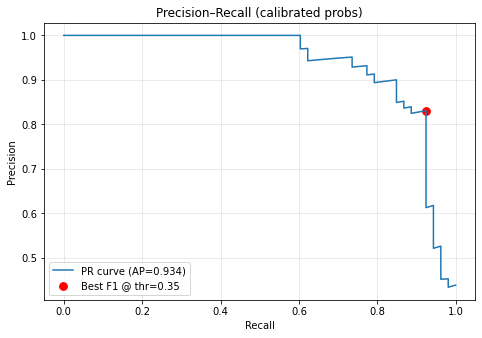

In [30]:
# === Threshold selection using CALIBRATED probabilities (p_sig) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, f1_score, classification_report,
    confusion_matrix, average_precision_score
)

# --- Inputs: calibrated probabilities and labels ---
p = np.asarray(p_sig).ravel()   # calibrated (Platt) probabilities on validation
y = np.asarray(yva).ravel()

# --- 1) Best threshold by F1 (default) ---
precision, recall, thresholds = precision_recall_curve(y, p)
# thresholds has len = len(precision) - 1
f1s = 2 * precision[1:] * recall[1:] / (precision[1:] + recall[1:] + 1e-12)
if len(thresholds) == 0:
    best_thr_f1 = 0.5
    best_f1 = f1_score(y, (p >= best_thr_f1).astype(int))
    idx_f1 = None
else:
    idx_f1 = int(np.argmax(f1s))
    best_thr_f1 = float(thresholds[idx_f1])
    best_f1     = float(f1s[idx_f1])

# --- 2) (Optional) Best threshold by COST (edit costs here) ---
cost_fp, cost_fn = 1.0, 1.0   # << cambia aquí si FN cuesta más que FP (p.ej. 10.0)
costs = []
for t in (thresholds if len(thresholds) else np.array([0.5])):
    yhat = (p >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat, labels=[0,1]).ravel()
    costs.append(cost_fp*fp + cost_fn*fn)
idx_cost = int(np.argmin(costs))
best_thr_cost = float((thresholds if len(thresholds) else np.array([0.5]))[idx_cost])
best_cost = float(costs[idx_cost])

# --- 3) Reports at F1-optimal threshold ---
yhat_f1 = (p >= best_thr_f1).astype(int)
print(f"[F1 criterion]  Best threshold: {best_thr_f1:.4f} | F1: {best_f1:.4f}")
print(classification_report(y, yhat_f1, digits=4))
print("Confusion matrix (F1-optimal threshold):\n", confusion_matrix(y, yhat_f1, labels=[0,1]))

# (Opcional) también puedes imprimir el de coste:
print(f"\n[Cost criterion] Best threshold: {best_thr_cost:.4f} | Cost: {best_cost:.2f}  (FP cost={cost_fp}, FN cost={cost_fn})")

# --- 4) Visualization: PR curve with F1-best point ---
ap = average_precision_score(y, p)
plt.figure(figsize=(6.8, 4.8))
plt.plot(recall, precision, label=f'PR curve (AP={ap:.3f})')
if idx_f1 is not None:
    plt.scatter(recall[idx_f1+1], precision[idx_f1+1], c='r', s=60,
                label=f'Best F1 @ thr={best_thr_f1:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall (calibrated probs)')
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

### Temperature Scaling + comparación + threshold F1 (validación)


                         brier   logloss  ece_uniform  mce_uniform  \
model                                                                
Platt (sigmoid)       0.038767  0.145798     0.060057     0.231722   
TempScaling(T=0.580)  0.034901  0.121054     0.038032     0.403846   
Uncalibrated          0.038811  0.143488     0.059417     0.277944   

                      ece_quantile  mce_quantile  intercept     slope  \
model                                                                   
Platt (sigmoid)           0.044168      0.140224   0.528139  1.964144   
TempScaling(T=0.580)      0.024736      0.123025   0.826734  1.190373   
Uncalibrated              0.043254      0.153013   0.742674  1.935757   

                      hosmer_lemeshow_stat  hosmer_lemeshow_p  
model                                                          
Platt (sigmoid)                  13.266793           0.102994  
TempScaling(T=0.580)              9.149883           0.329810  
Uncalibrated               

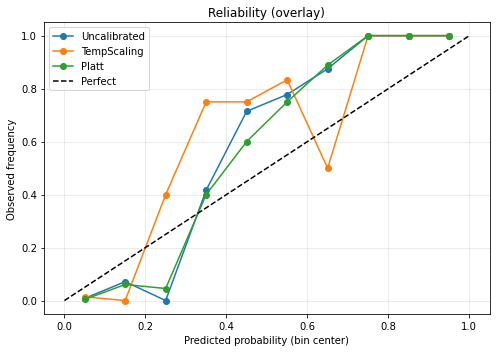

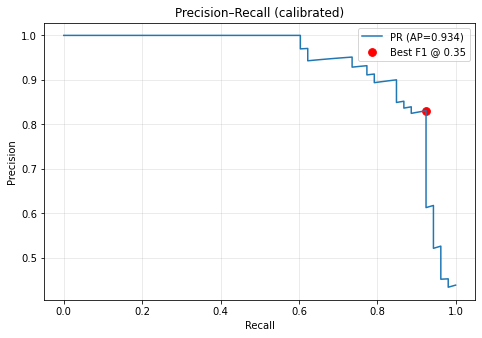

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    brier_score_loss, log_loss, precision_recall_curve, confusion_matrix,
    classification_report, average_precision_score
)
from scipy.special import expit, logit
from scipy.optimize import minimize_scalar
from scipy.stats import chi2

# ---------- Helpers ----------
def logit_clip(p, eps=1e-6):
    p = np.asarray(p).clip(eps, 1-eps)
    return np.log(p/(1-p))

def ece_mce_uniform(y, p, n_bins=10):
    y = np.asarray(y).ravel(); p = np.asarray(p).ravel()
    edges = np.linspace(0,1,n_bins+1); ece=0.0; mce=0.0; N=len(y)
    for i in range(n_bins):
        lo, hi = edges[i], edges[i+1]
        idx = (p>=lo) & (p<hi) if i<n_bins-1 else (p>=lo) & (p<=hi)
        if idx.any():
            gap = abs(y[idx].mean() - p[idx].mean())
            w   = idx.mean()
            ece += w*gap
            mce = max(mce, gap)
    return ece, mce

def ece_mce_quantile(y, p, n_bins=10):
    y = np.asarray(y).ravel(); p = np.asarray(p).ravel()
    qs = np.linspace(0,1,n_bins+1)
    edges = np.quantile(p, qs)
    # de-duplicate edges
    edges = np.unique(edges)
    if len(edges) < 3:  # muy degenerado
        return np.nan, np.nan
    ece=0.0; mce=0.0; N=len(y)
    weights=[]
    for i in range(len(edges)-1):
        lo, hi = edges[i], edges[i+1]
        idx = (p>=lo) & (p<=hi) if i==len(edges)-2 else (p>=lo) & (p<hi)
        if idx.any():
            gap = abs(y[idx].mean() - p[idx].mean())
            w   = idx.sum()/N
            ece += w*gap
            mce = max(mce, gap)
            weights.append(w)
    return ece, mce

def hosmer_lemeshow(y, p, n_bins=10):
    y = np.asarray(y).ravel(); p = np.asarray(p).ravel()
    # cuantiles para repartir observaciones
    qs = np.linspace(0,1,n_bins+1)
    edges = np.quantile(p, qs)
    edges = np.unique(edges)
    B = len(edges)-1
    if B < 3:
        return np.nan, np.nan
    stat = 0.0
    df = B - 2
    for i in range(B):
        lo, hi = edges[i], edges[i+1]
        idx = (p>=lo) & (p<=hi) if i==B-1 else (p>=lo) & (p<hi)
        if idx.any():
            n_i = idx.sum()
            p_i = p[idx].mean()
            o_i = y[idx].sum()
            e_i = n_i * p_i
            var = n_i * p_i * (1 - p_i)
            if var > 0:
                stat += (o_i - e_i)**2 / var
    pval = chi2.sf(stat, df) if df>0 else np.nan
    return stat, pval

def calibration_summary(y, p):
    y = np.asarray(y).ravel(); p = np.asarray(p).ravel()
    out = {
        "brier": brier_score_loss(y, p),
        "logloss": log_loss(y, p, labels=[0,1])
    }
    e_u, m_u = ece_mce_uniform(y, p, n_bins=10)
    e_q, m_q = ece_mce_quantile(y, p, n_bins=10)
    out["ece_uniform"], out["mce_uniform"] = e_u, m_u
    out["ece_quantile"], out["mce_quantile"] = e_q, m_q
    # Spiegelhalter: regresa intercept y slope de y ~ logit(p)
    Z = logit_clip(p).reshape(-1,1)
    # resolvemos por mínimos cuadrados de GLM approx:
    # pero para un resumen simple usamos la regresión logística
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(Z, y)
    out["intercept"] = float(lr.intercept_[0])
    out["slope"]     = float(lr.coef_[0][0])
    hl_stat, hl_p = hosmer_lemeshow(y, p, n_bins=10)
    out["hosmer_lemeshow_stat"] = hl_stat
    out["hosmer_lemeshow_p"]    = hl_p
    return out

# ---------- 1) Probabilidades sin calibrar (validación) ----------
Xva_proc = Xva  # asegúrate de usar el mismo orden de columnas que en train
p_uncal = base_model_full.predict_proba(Xva_proc)[:,1]
y = np.asarray(yva).ravel()

# ---------- 2) Temperature Scaling (fit T por logloss) ----------
def calibrate_temp(p, T):
    return expit(logit_clip(p)/T)

def objective_T(T):
    pc = calibrate_temp(p_uncal, T)
    return log_loss(y, pc, labels=[0,1])

res = minimize_scalar(objective_T, bounds=(0.2, 5.0), method='bounded')
T_opt = float(res.x)
p_temp = calibrate_temp(p_uncal, T_opt)

# ---------- 3) (Opcional) Platt si lo tienes en memoria ----------
have_platt = 'platt_lr' in globals()
if have_platt:
    p_platt = platt_lr.predict_proba(logit_clip(p_uncal).reshape(-1,1))[:,1]

# ---------- 4) Resumen de calibración ----------
rows = []
rows.append(("Uncalibrated", calibration_summary(y, p_uncal)))
rows.append((f"TempScaling(T={T_opt:.3f})", calibration_summary(y, p_temp)))
if have_platt:
    rows.append(("Platt (sigmoid)", calibration_summary(y, p_platt)))

summary = pd.DataFrame(
    [{**m, "model": name} for name, m in rows]
).set_index("model").sort_index()
print(summary.round(6))

# ---------- 5) Elegir umbral por F1 usando la calibración elegida ----------
# Elige aquí la versión para umbral: p_use = p_temp (TS) o p_platt (Platt)
p_use = p_platt if have_platt else p_temp   # cambia si prefieres TS

precision, recall, thresholds = precision_recall_curve(y, p_use)
f1s = 2*precision[1:]*recall[1:]/(precision[1:]+recall[1:]+1e-12)
idx = int(np.argmax(f1s)) if len(f1s)>0 else 0
thr_best = float(thresholds[idx]) if len(thresholds)>0 else 0.5
yhat = (p_use >= thr_best).astype(int)

print(f"\nBest threshold (F1) @ calibrated: {thr_best:.4f}, F1={f1s[idx]:.4f}")
print(classification_report(y, yhat, digits=4))
print("Confusion matrix:\n", confusion_matrix(y, yhat, labels=[0,1]))

# ---------- 6) Visual: reliability overlay ----------
def rel_points(y, p, n_bins=10):
    edges = np.linspace(0,1,n_bins+1)
    centers = 0.5*(edges[:-1]+edges[1:])
    obs = np.full(n_bins, np.nan); cnt = np.zeros(n_bins, int)
    for i in range(n_bins):
        lo, hi = edges[i], edges[i+1]
        idx = (p>=lo) & (p<hi) if i<n_bins-1 else (p>=lo) & (p<=hi)
        if idx.any():
            obs[i] = y[idx].mean(); cnt[i]=idx.sum()
    return centers, obs, cnt

plt.figure(figsize=(7,5))
for name, p_ in [("Uncalibrated", p_uncal), ("TempScaling", p_temp)] + ([("Platt", p_platt)] if have_platt else []):
    c, o, _ = rel_points(y, p_)
    plt.plot(c, o, marker='o', label=name)
plt.plot([0,1],[0,1],'k--',label='Perfect')
plt.xlabel('Predicted probability (bin center)'); plt.ylabel('Observed frequency')
plt.title('Reliability (overlay)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ---------- 7) Visual: PR curve con punto óptimo ----------
ap = average_precision_score(y, p_use)
plt.figure(figsize=(6.8,4.8))
plt.plot(recall, precision, label=f'PR (AP={ap:.3f})')
if len(thresholds)>0:
    plt.scatter(recall[idx+1], precision[idx+1], c='r', s=60,
                label=f'Best F1 @ {thr_best:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall (calibrated)')
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


In [32]:
# SHAP for XGBoost (model_output='probability' para interpretar en puntos de prob.)
import numpy as np
import shap

# Asegura mismo orden de columnas que en train
Xva_proc = Xva[Xtr.columns].copy()

# Explainer (si tu versión de shap da problemas con 'probability', cambia a margin)
try:
    explainer = shap.TreeExplainer(
        base_model_full,
        model_output='probability',
        feature_perturbation='tree_path_dependent'
    )
    shap_values = explainer.shap_values(Xva_proc)
    expected_value = explainer.expected_value
except Exception as e:
    print("Fallo con model_output='probability' -> uso 'margin' (log-odds). Detalle:", e)
    explainer = shap.TreeExplainer(base_model_full)
    shap_values = explainer.shap_values(Xva_proc)
    expected_value = explainer.expected_value

print("SHAP listo. Matrix shape:", np.array(shap_values).shape)
print("Expected value:", expected_value)


Fallo con model_output='probability' -> uso 'margin' (log-odds). Detalle: Only model_output="raw" is supported for feature_perturbation="tree_path_dependent"
SHAP listo. Matrix shape: (358, 27)
Expected value: -1.8921006


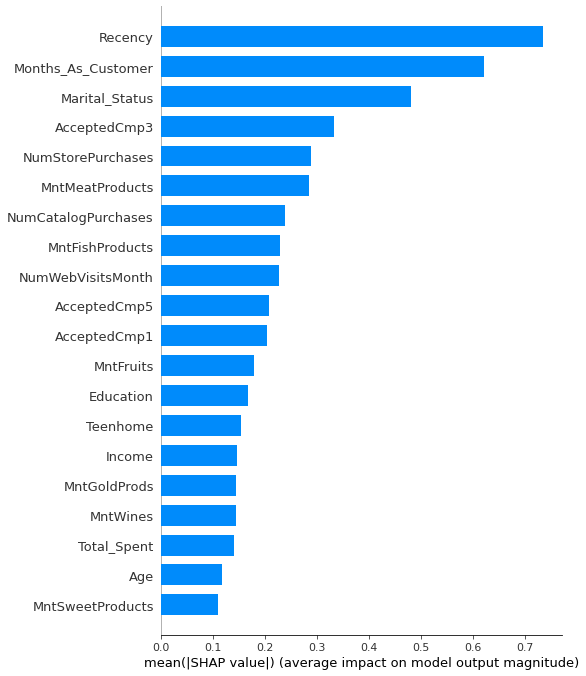

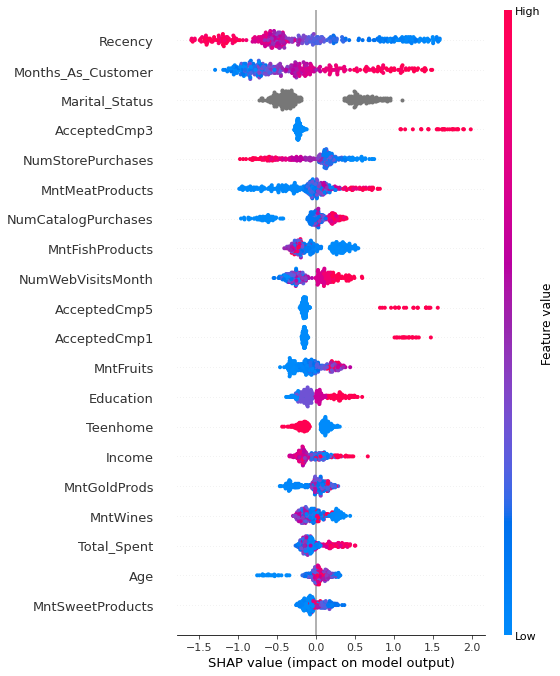

In [33]:
# Usa Xva_proc y shap_values que ya calculaste en la celda anterior (log-odds)
import shap

# Importancia global (media de |SHAP|)
shap.summary_plot(shap_values, Xva_proc, plot_type='bar', max_display=20, show=True)

# Beeswarm: dispersión de efectos por variable
shap.summary_plot(shap_values, Xva_proc, max_display=20, show=True)

Top features: ['Recency', 'Months_As_Customer', 'Marital_Status', 'AcceptedCmp3', 'NumStorePurchases', 'MntMeatProducts']


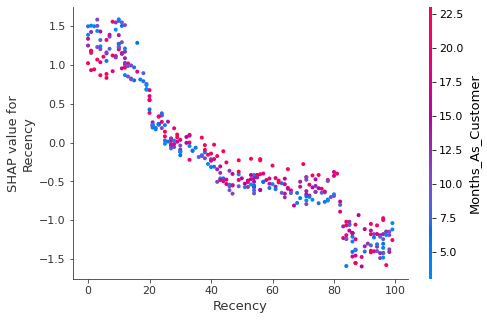

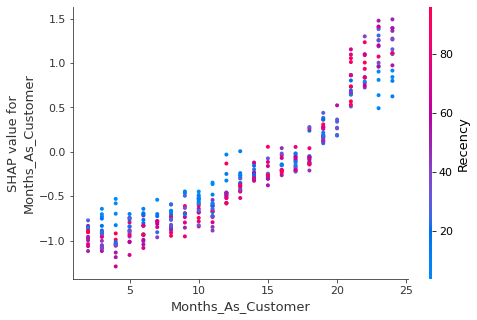

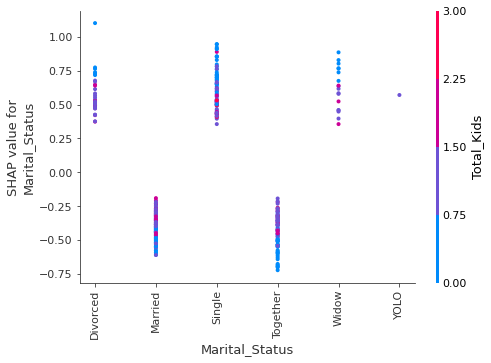

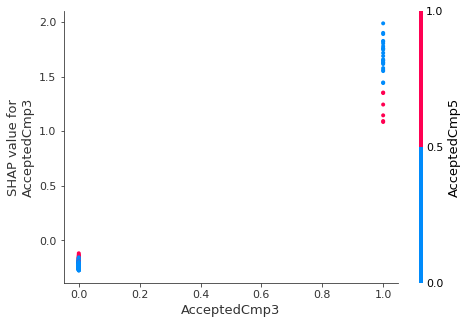

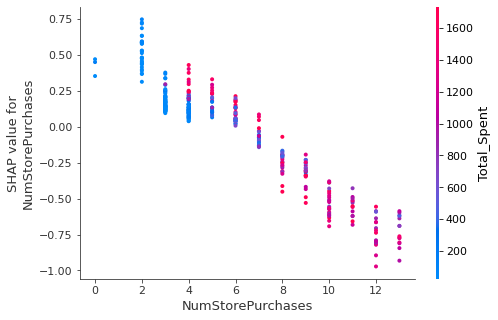

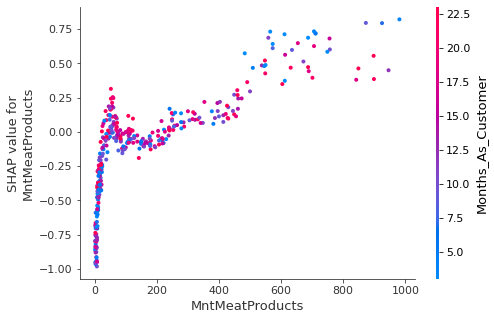

In [34]:
import numpy as np
import shap

# Top-N por |SHAP| medio
mean_abs = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(-mean_abs)[:6]
top_feats = [Xva_proc.columns[i] for i in top_idx]
print("Top features:", top_feats)

# Un gráfico por feature; SHAP colorea por la variable de interacción más relevante
for f in top_feats:
    shap.dependence_plot(f, shap_values, Xva_proc, interaction_index='auto', show=True)

In [35]:
import numpy as np
import pandas as pd
from scipy.special import expit
from scipy.stats import spearmanr

# ==== CONFIG ====
TOP_K = 10      # cuántos drivers globales mostrar
TOP_CAT = 5     # cuántas categorías por variable categórica
SEED = 42

# ==== Helpers ====
def pp_from_logodds(delta_lo, lo_base):
    """Convierte contribuciones SHAP (log-odds) a p.p. respecto de la base."""
    return expit(lo_base + delta_lo) - expit(lo_base)

def describe_direction(x, s):
    if np.isnan(s): 
        return "sin relación monótona clara"
    if s >= 0.25: 
        return "a mayor valor, ↑ prob. de respuesta"
    if s <= -0.25: 
        return "a mayor valor, ↓ prob. de respuesta"
    if s >= 0.10:
        return "relación positiva suave"
    if s <= -0.10:
        return "relación negativa suave"
    return "sin relación monótona clara"

def action_hint(feature):
    f = feature.lower()
    if "recency" in f:
        return "Reactivación: emails/SMS con incentivo escalonado por tiempo desde última compra."
    if "webvisits" in f or "web" in f and "purchases" not in f:
        return "Remarketing: audiencias de alta intención (visitas sin compra) con creatives dinámicos."
    if "webpurchases" in f:
        return "Potenciar canal web: promociones en sitio/UX, cross-sell post-checkout."
    if "storepurchases" in f:
        return "Promos omnicanal: cupones en tienda + retargeting digital."
    if "catalog" in f:
        return "Acciones direct-mail/email personalizadas; test A/B con call-to-action más claro."
    if "deals" in f or "discount" in f:
        return "Segmento sensible a precio: descuentos controlados, bundles y ventanas de oferta cortas."
    if "income" in f:
        return "Propuesta premium/upsell; mensajes de valor y servicio."
    if "age" in f or "kids" in f or "teen" in f:
        return "Segmentación por ciclo de vida: creativos y timing adaptados."
    if "acceptedcmp" in f or "response" in f:
        return "Lookalikes de responders; secuencias de nurturing específicas."
    if "mnt" in f or "spent" in f:
        return "Recomendaciones/CRM basadas en categorías más afines (wine, meat, etc.)."
    return "Probar mensajes/segmentos específicos y medir lift por cohorte."

# ==== Detectar tipos de variable ====
cat_cols = [c for c in Xva_proc.columns if str(Xva_proc[c].dtype) in ("category","object")]
num_cols = [c for c in Xva_proc.columns if c not in cat_cols]

# ==== Importancias globales ====
mean_abs = np.abs(shap_values).mean(axis=0)
order = np.argsort(-mean_abs)
feat_order = [Xva_proc.columns[i] for i in order]
imp_df = pd.DataFrame({
    "feature": feat_order,
    "mean_abs_shap_logodds": mean_abs[order],
})
imp_df["mean_abs_shap_pp"] = pp_from_logodds(imp_df["mean_abs_shap_logodds"].values, expected_value)

print("=== Top drivers globales (media de |SHAP|) ===")
display(imp_df.head(TOP_K).style.format({
    "mean_abs_shap_logodds": "{:.4f}",
    "mean_abs_shap_pp": "{:+.3%}"
}))

# ==== Resumen por variable (dirección y magnitud) ====
rows = []
for j, f in enumerate(Xva_proc.columns):
    shap_f = shap_values[:, j]
    # dirección (Spearman) para numéricas; para categóricas no tiene sentido directo
    if f in num_cols:
        x = pd.to_numeric(Xva_proc[f], errors='coerce')
        mask = ~pd.isna(x)
        rho = spearmanr(x[mask], shap_f[mask]).correlation
    else:
        rho = np.nan
    
    # impacto medio en p.p. (aprox)
    delta_pp_mean = pp_from_logodds(np.mean(shap_f), expected_value)
    delta_pp_abs  = np.mean(np.abs(pp_from_logodds(shap_f, expected_value)))
    
    rows.append({
        "feature": f,
        "type": "numeric" if f in num_cols else "categorical",
        "spearman_shap": rho,
        "mean_delta_pp": float(delta_pp_mean),
        "mean_abs_delta_pp": float(delta_pp_abs)
    })

summary = pd.DataFrame(rows).sort_values("mean_abs_delta_pp", ascending=False)
print("=== Resumen de dirección & magnitud (aprox p.p.) ===")
display(summary.head(TOP_K).style.format({
    "spearman_shap": "{:+.3f}",
    "mean_delta_pp": "{:+.2%}",
    "mean_abs_delta_pp": "{:.2%}"
}))

# ==== Detalle para categóricas: ranking de categorías por contribución media ====
cat_tables = {}
for f in cat_cols:
    tbl = (
        pd.DataFrame({"cat": Xva_proc[f].astype(str).values, "shap": shap_values[:, Xva_proc.columns.get_loc(f)]})
        .groupby("cat")["shap"].agg(["mean","count"])
        .assign(delta_pp=lambda d: pp_from_logodds(d["mean"].values, expected_value))
        .sort_values("delta_pp", ascending=False)
    )
    cat_tables[f] = tbl

print("=== Top categorías (contribución media en p.p.) ===")
for f, tbl in cat_tables.items():
    print(f"\n• {f}:")
    display(tbl.head(TOP_CAT).style.format({"mean":"{:+.4f}", "delta_pp":"{:+.2%}"}))

# ==== Redactar insights ejecutivos ====
print("\n=== Executive summary (auto-generado) ===\n")
top_feats = summary.head(TOP_K)["feature"].tolist()
for f in top_feats:
    row = summary.loc[summary["feature"]==f].iloc[0]
    direction = describe_direction(None, row["spearman_shap"])
    hint = action_hint(f)
    print(f"- {f}: impacto medio ≈ {row['mean_abs_delta_pp']:.2%} p.p.; {direction}. Sugerencia: {hint}")

# ==== (Opcional) vincular al umbral/calibración si están en memoria ====
if "p_temp" in globals() and "thr_best" in globals():
    from sklearn.metrics import classification_report, confusion_matrix
    y_true = np.asarray(yva).ravel()
    y_hat  = (p_temp >= thr_best).astype(int)
    print(f"\nUmbral final (calibrado): {thr_best:.3f}")
    print(classification_report(y_true, y_hat, digits=4))
    print("Matriz de confusión:\n", confusion_matrix(y_true, y_hat, labels=[0,1]))


=== Top drivers globales (media de |SHAP|) ===


=== Resumen de dirección & magnitud (aprox p.p.) ===


=== Top categorías (contribución media en p.p.) ===

• Marital_Status:



=== Executive summary (auto-generado) ===

- Recency: impacto medio ≈ 8.34% p.p.; a mayor valor, ↓ prob. de respuesta. Sugerencia: Reactivación: emails/SMS con incentivo escalonado por tiempo desde última compra.
- Months_As_Customer: impacto medio ≈ 6.76% p.p.; a mayor valor, ↑ prob. de respuesta. Sugerencia: Probar mensajes/segmentos específicos y medir lift por cohorte.
- Marital_Status: impacto medio ≈ 5.71% p.p.; sin relación monótona clara. Sugerencia: Probar mensajes/segmentos específicos y medir lift por cohorte.
- AcceptedCmp3: impacto medio ≈ 4.53% p.p.; a mayor valor, ↑ prob. de respuesta. Sugerencia: Lookalikes de responders; secuencias de nurturing específicas.
- NumStorePurchases: impacto medio ≈ 3.15% p.p.; a mayor valor, ↓ prob. de respuesta. Sugerencia: Promos omnicanal: cupones en tienda + retargeting digital.
- MntMeatProducts: impacto medio ≈ 3.02% p.p.; a mayor valor, ↑ prob. de respuesta. Sugerencia: Recomendaciones/CRM basadas en categorías más afines (wine, mea